![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+Forecasting&dt=BQML+Regression+Based+Forecasting.ipynb)

# BQML Regression Based Forecasting
# (IN DEVELOPMENT)

TODO:
- [X] four examples:
    - [X] 1 - time features - Linear Regression
    - [X] 2 - add lags features - Linear Regression
    - [X] 3 - use leads for multi-step model - Linear Regression
    - [X] 4 - use leas for multi-step model - Boosted Tree
- [X] add comparison
- [ ] consider adding recursiver version of boosted tree model as 4, then 4->5
- [ ] consider direct recursive predictions for multi-step models
- [ ] writeup notes

Time series based forecasting methods are covered in this series [Applied Forecasting](./readme.md) series. Most of the methods used in this series are time series focused methods trend modeling with ARIMA, additive models like Prophet, and specially designed neural networks.  

This notebook will walk through the concepts of using regression approach to time series modeling. I like to think of this a prediction based approaches to forecasting based on leads (a view into future) and lags (a view into the past).  

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [17]:
REGION = 'us-central1'
EXPERIMENT = 'regression'
SERIES = 'applied-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = 'forecasting-1_prepped'

viz_limit = 12

packages:

In [191]:
from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from time import sleep

clients:

In [5]:
bq = bigquery.Client(project = PROJECT_ID)

---
## Review Time Series

In [6]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'

Retrieve Key Dates for splits:

In [7]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            GROUP BY splits
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE splits ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE splits = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE splits = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates

start_date   val_start  test_start    end_date
0  2013-07-01  2016-09-03  2016-09-17  2016-09-30

Retrieve raw data:

In [8]:
query = f"""
    SELECT {SERIES_COLUMN}, {TIME_COLUMN}, splits, {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()

### Plot Time Series

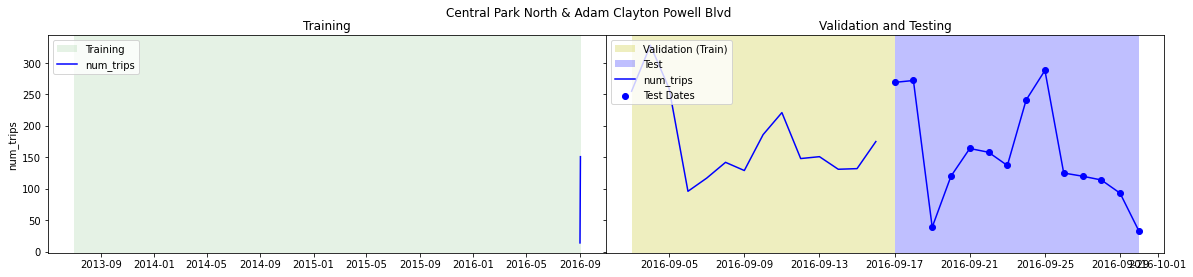

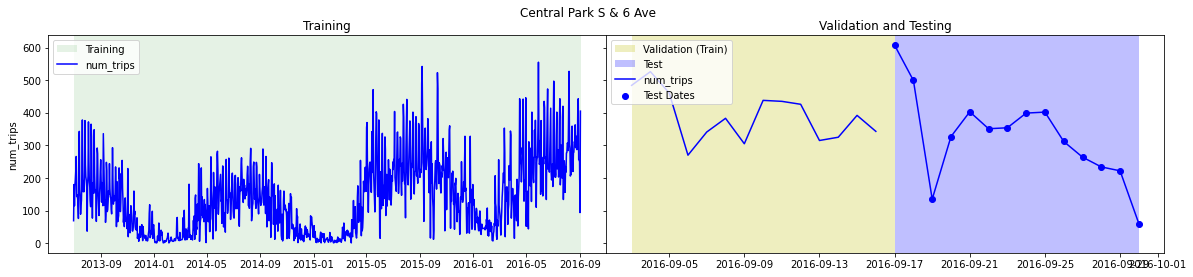

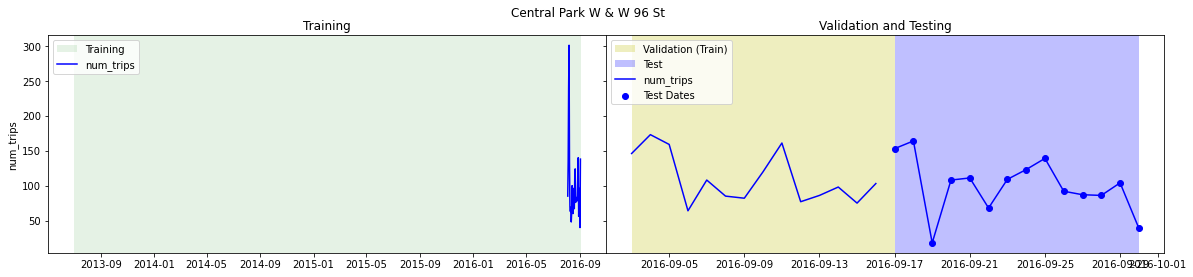

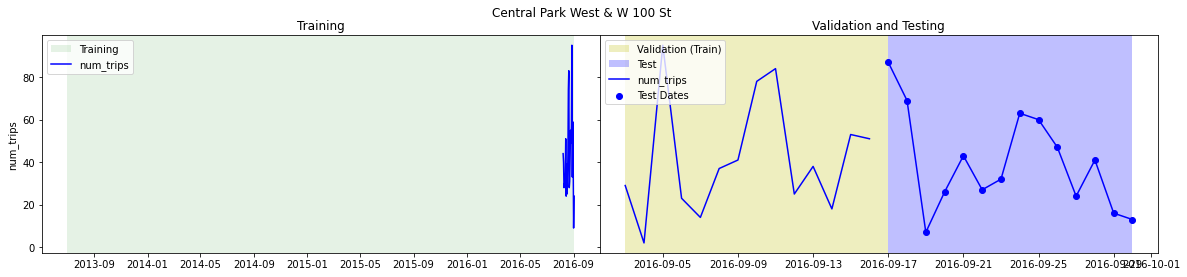

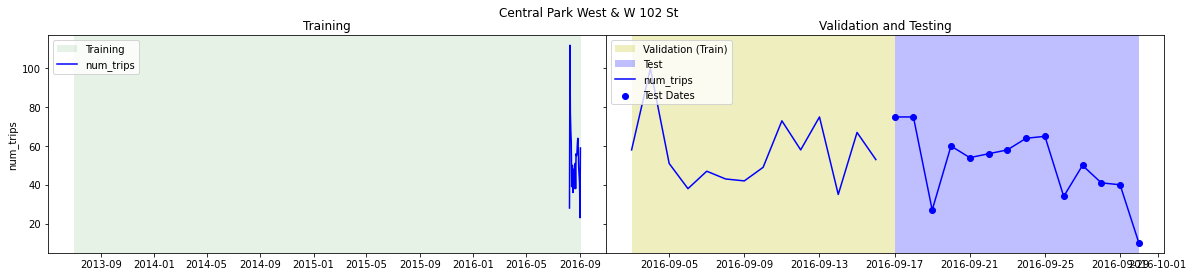

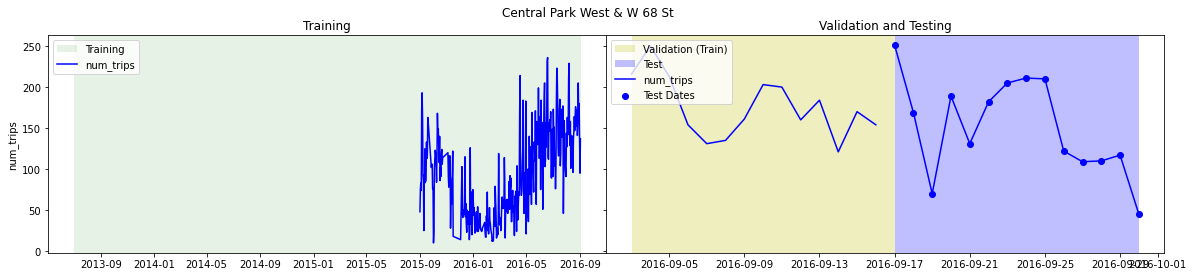

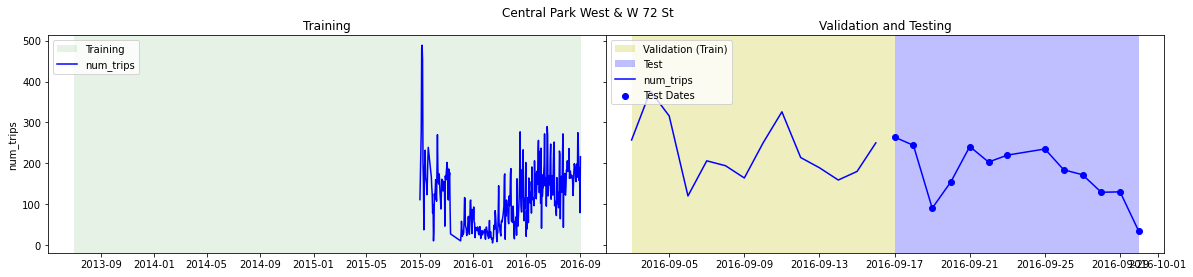

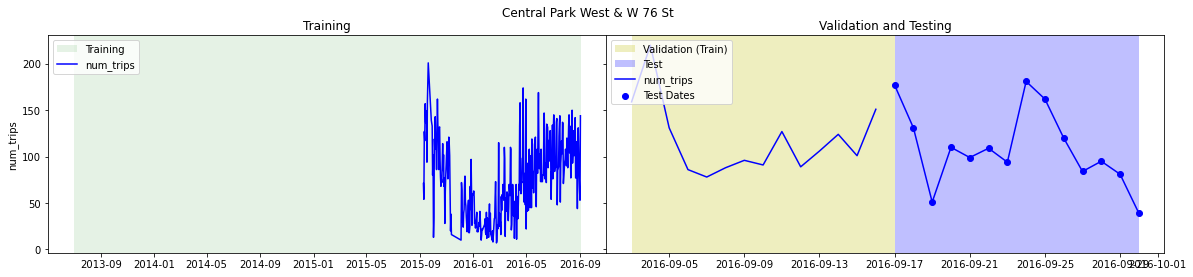

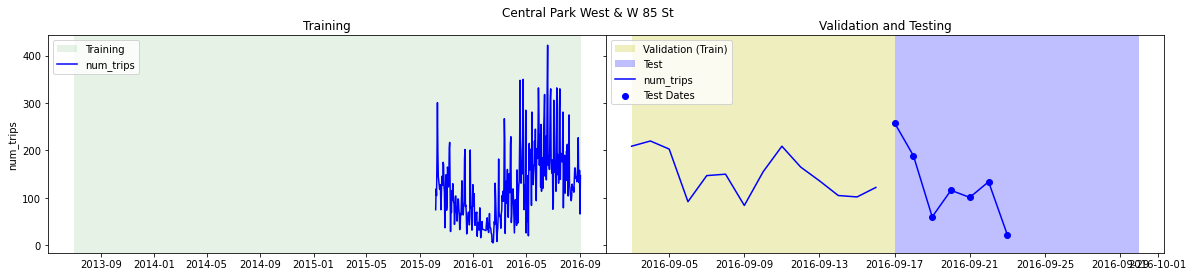

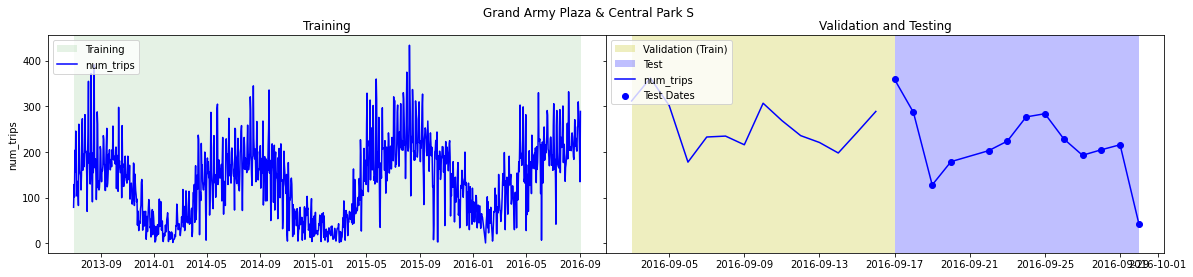

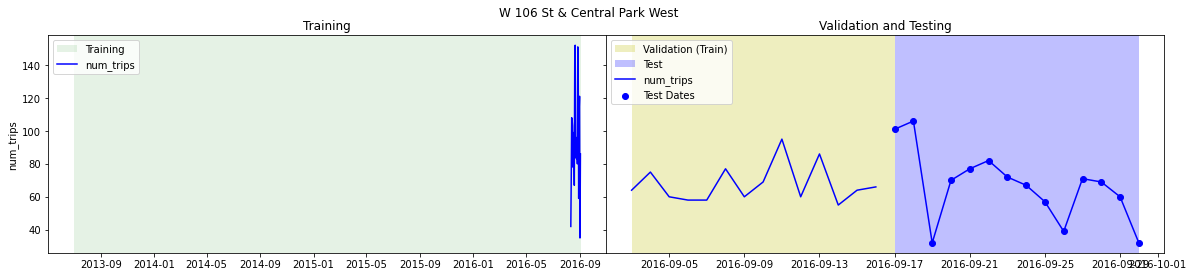

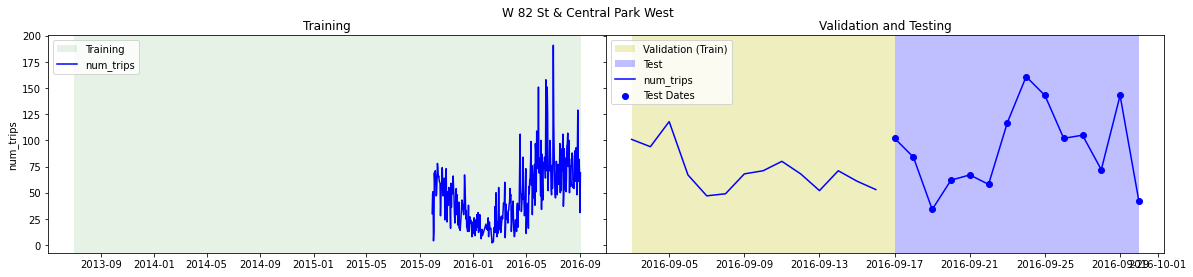

In [9]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')
        axes[1].scatter(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b', label = 'Test Dates')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st)

        # display result
        plt.show()

---
## Linear Regression - Example 1
- Prediction - What is demand today based on
- Using Time Features: Week, Month, Year, Day, ...

Regression methods don't know about time/date based data types.  To get started, lets first decompose the `TIME_COLUMN` into parts like year, month, day, day of week and model with a linear regression to find the optimal weights of these components.

In [150]:
EX1_CTE = f"""
WITH EX1_CTE AS (
    SELECT
        {TARGET_COLUMN},
        {SERIES_COLUMN},
        splits,
        
        # TIME FEATURES
        EXTRACT(YEAR FROM {TIME_COLUMN}) AS Year,
        EXTRACT(MONTH FROM {TIME_COLUMN}) AS Month,
        EXTRACT(DAY FROM {TIME_COLUMN}) AS Day_of_Month,
        EXTRACT(DAYOFYEAR FROM {TIME_COLUMN}) AS Day_of_Year,
        EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) AS Day_of_Week,
        CASE WHEN EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) IN (1, 7) THEN 1 ELSE 0 END AS Weekend,
        
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
)
"""

In [151]:
BQ_MODEL = f"{BQ_TABLE}_Regression_Example_1"
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (
        model_type = 'LINEAR_REG',
        input_label_cols = ['{TARGET_COLUMN}'],
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM'
    ) AS
    {EX1_CTE}
    SELECT
        * EXCEPT(splits),
        CASE
            WHEN splits = 'TRAIN' THEN FALSE
            ELSE TRUE
        END AS custom_splits
    FROM EX1_CTE
    WHERE splits in ('TRAIN', 'VALIDATE')
"""
job = bq.query(query = query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 15.473


In [152]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sapplied_forecasting!3sforecasting-1_prepped_Regression_Example_1


In [153]:
query = f"""
SELECT *
FROM ML.WEIGHTS (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
weights = bq.query(query = query).to_dataframe()
weights

processed_input        weight  \
0  start_station_name           NaN   
1                Year     42.671947   
2               Month    988.641558   
3        Day_of_Month     32.555400   
4         Day_of_Year    -32.181374   
5         Day_of_Week     -0.614223   
6             Weekend     45.698300   
7       __INTERCEPT__ -39067.341842   

                                    category_weights  
0  [{'category': 'Central Park West & W 72 St', '...  
1                                                 []  
2                                                 []  
3                                                 []  
4                                                 []  
5                                                 []  
6                                                 []  
7                                                 []

In [154]:
weights['category_weights'].iloc[0]

array([{'category': 'Central Park West & W 72 St', 'weight': -47895.967477630365},
       {'category': 'Central Park S & 6 Ave', 'weight': -47838.94486669657},
       {'category': 'Grand Army Plaza & Central Park S', 'weight': -47843.058354479304},
       {'category': 'Central Park West & W 102 St', 'weight': -47975.938563577365},
       {'category': 'Central Park West & W 85 St', 'weight': -47888.343621033695},
       {'category': 'Central Park West & W 100 St', 'weight': -47985.59240973121},
       {'category': 'Central Park North & Adam Clayton Powell Blvd', 'weight': -47919.50515463918},
       {'category': 'W 82 St & Central Park West', 'weight': -47966.83438821973},
       {'category': 'Central Park West & W 76 St', 'weight': -47937.41907373198},
       {'category': 'Central Park W & W 96 St', 'weight': -47930.11903755435},
       {'category': 'W 106 St & Central Park West', 'weight': -47934.23573082751},
       {'category': 'Central Park West & W 68 St', 'weight': -47920.1820723

In [156]:
query = f"""
{EX1_CTE}
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM EX1_CTE WHERE SPLITS='TEST'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM EX1_CTE WHERE SPLITS='VALIDATE'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM EX1_CTE WHERE SPLITS='TRAIN'))
"""
bq.query(query = query).to_dataframe()

SPLIT  mean_absolute_error  mean_squared_error  mean_squared_log_error  \
0     TRAIN            52.547008         4819.465819                0.676781   
1      TEST            50.051585         5615.421813                0.272105   
2  VALIDATE            60.772229         7715.211259                0.312313   

   median_absolute_error  r2_score  explained_variance  
0              41.346673  0.359895            0.359895  
1              30.539519  0.449021            0.546828  
2              35.577067  0.319344            0.577856

In [161]:
query = f"""
{EX1_CTE}
SELECT
    {SERIES_COLUMN},
    DATE(year, month, day_of_month) AS {TIME_COLUMN},
    predicted_{TARGET_COLUMN} AS predicted
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM EX1_CTE
    )
  )
ORDER BY Year, Month, Day_of_Month
"""
pred_ex1 = bq.query(query = query).to_dataframe()

In [162]:
pred_ex1

start_station_name   starttime   predicted
0                Central Park S & 6 Ave  2013-07-01   87.150676
1     Grand Army Plaza & Central Park S  2013-07-01   83.037188
2     Grand Army Plaza & Central Park S  2013-07-02   82.796991
3                Central Park S & 6 Ave  2013-07-02   86.910479
4     Grand Army Plaza & Central Park S  2013-07-03   82.556794
...                                 ...         ...         ...
4377        Central Park West & W 76 St  2016-09-30   74.938701
4378        W 82 St & Central Park West  2016-09-30   45.523387
4379  Grand Army Plaza & Central Park S  2016-09-30  169.299420
4380        Central Park West & W 68 St  2016-09-30   92.175703
4381             Central Park S & 6 Ave  2016-09-30  173.412908

[4382 rows x 3 columns]

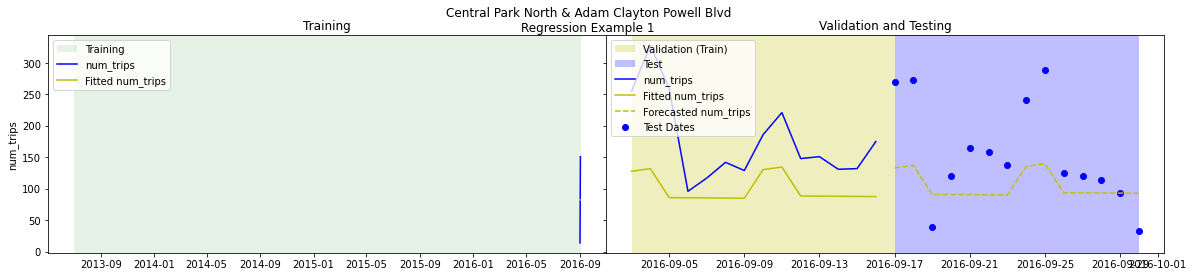

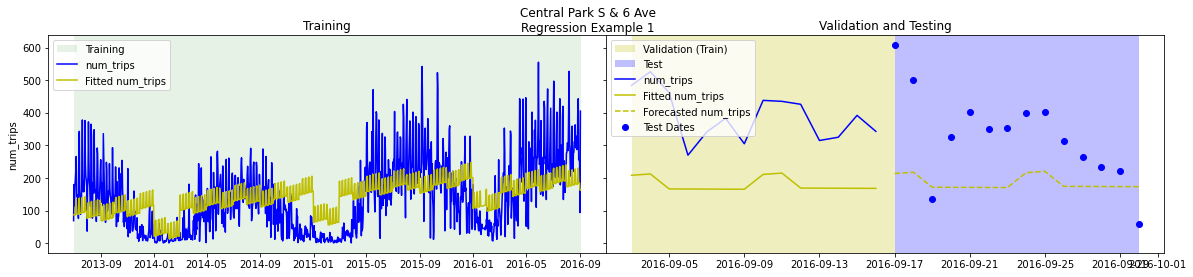

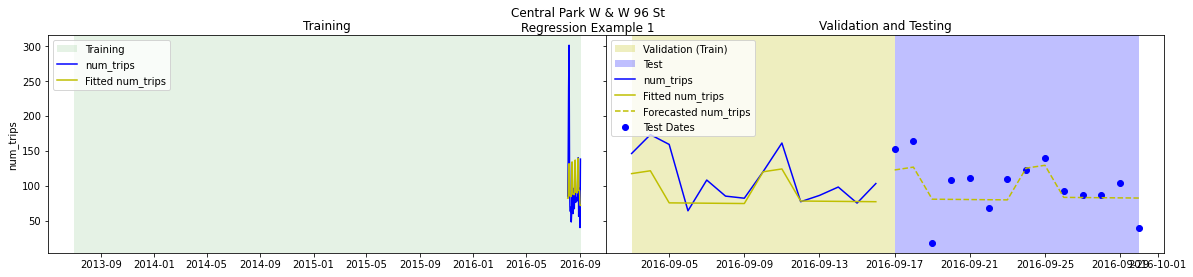

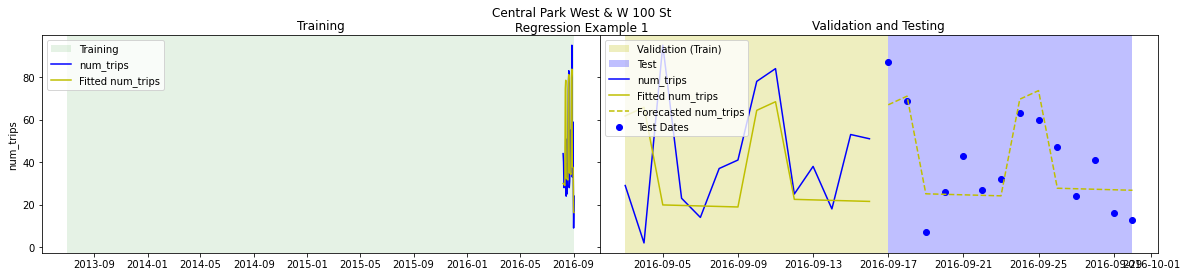

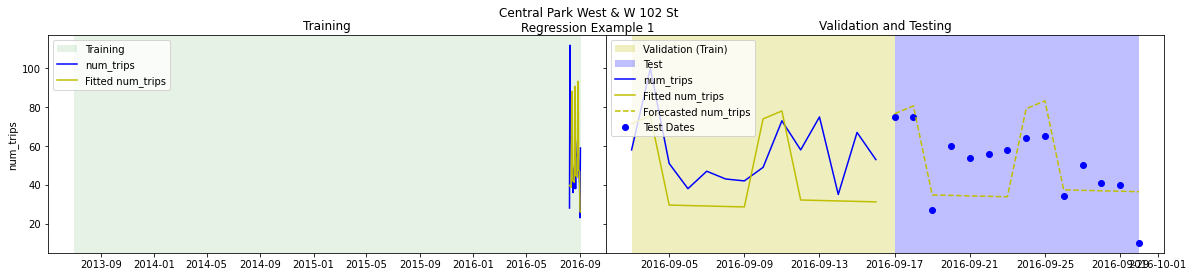

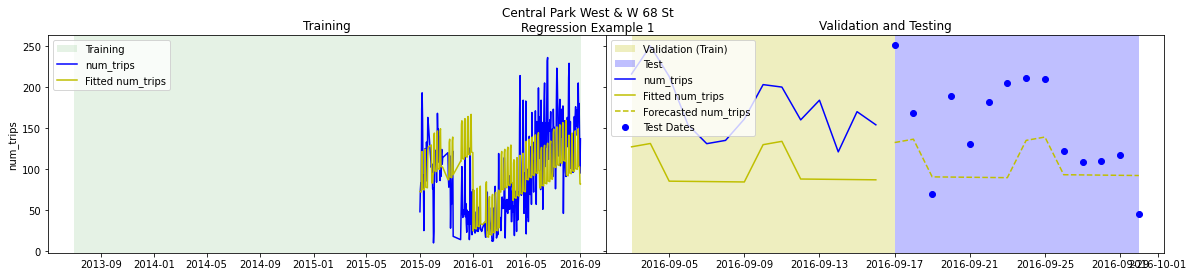

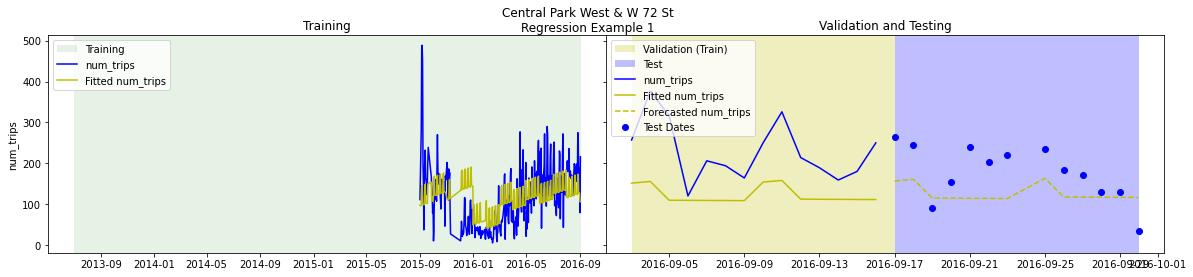

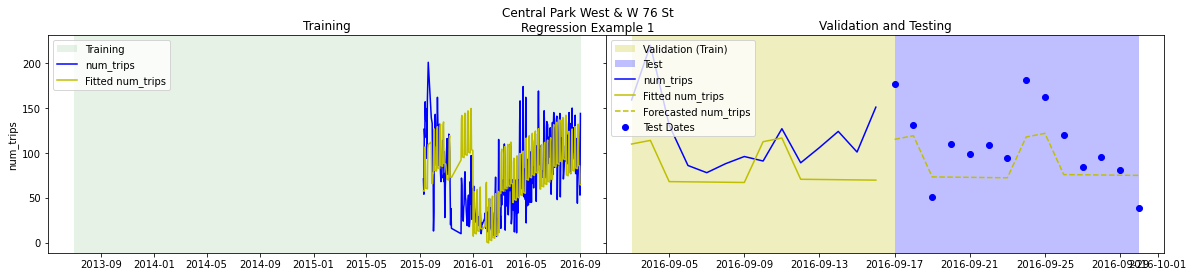

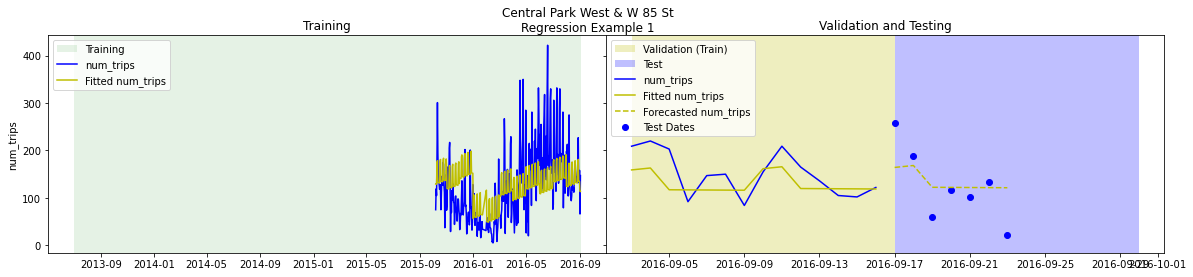

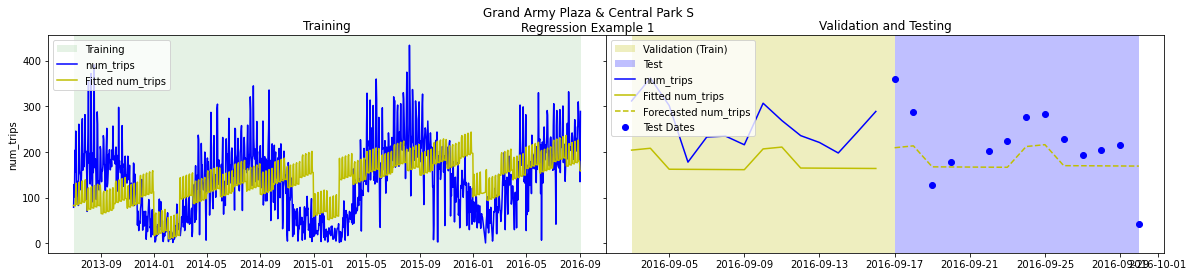

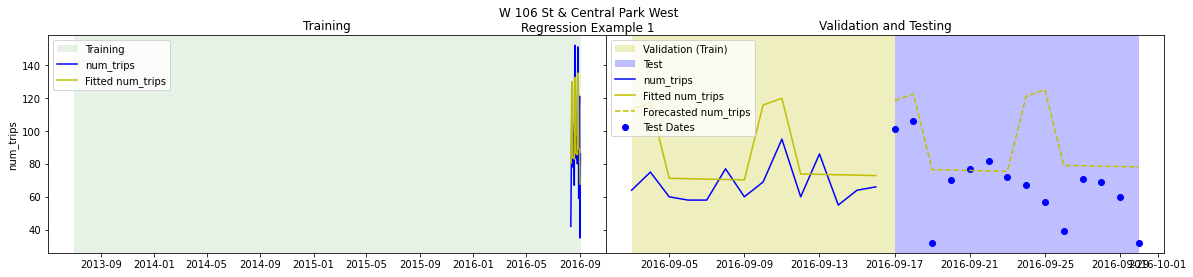

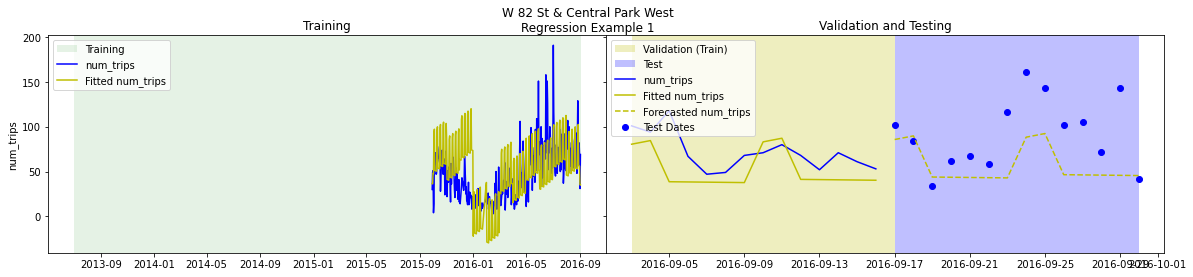

In [163]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]
        fit_traindf = pred_ex1[(pred_ex1[SERIES_COLUMN] == st) & (pred_ex1[TIME_COLUMN] < keyDates['val_start'][0])]
        fit_valdf = pred_ex1[(pred_ex1[SERIES_COLUMN] == st) & (pred_ex1[TIME_COLUMN] >= keyDates['val_start'][0]) & (pred_ex1[TIME_COLUMN] < keyDates['test_start'][0])]
        fit_testdf = pred_ex1[(pred_ex1[SERIES_COLUMN] == st) & (pred_ex1[TIME_COLUMN] >= keyDates['test_start'][0])]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
        #axes[1].fill_between(fit_testdf[TIME_COLUMN], fit_testdf['prediction_interval_lower_bound'], fit_testdf['prediction_interval_upper_bound'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        #axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        axes[0].plot(fit_traindf[TIME_COLUMN], fit_traindf['predicted'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_valdf[TIME_COLUMN], fit_valdf['predicted'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_testdf[TIME_COLUMN], fit_testdf['predicted'], color = 'y', label = f'Forecasted {TARGET_COLUMN}', linestyle='dashed')

        axes[1].scatter(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b', label = 'Test Dates')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st + f"\nRegression Example 1")

        # display result
        plt.show()

---
## Linear Regression - Example 2
- Prediction - What is demand today based on
- Using Time Features: Week, Month, Year, Day, ...
- Using Lags for 1 day, 1 week (7), 1 month (28), 1 quarter (90), 1 year


In [266]:
EX2_CTE = f"""
WITH EX2_CTE AS (
    SELECT
        {TARGET_COLUMN},
        {SERIES_COLUMN},
        splits,
        
        # TIME FEATURES
        EXTRACT(YEAR FROM {TIME_COLUMN}) AS Year,
        EXTRACT(MONTH FROM {TIME_COLUMN}) AS Month,
        EXTRACT(DAY FROM {TIME_COLUMN}) AS Day_of_Month,
        EXTRACT(DAYOFYEAR FROM {TIME_COLUMN}) AS Day_of_Year,
        EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) AS Day_of_Week,
        CASE WHEN EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) IN (1, 7) THEN 1 ELSE 0 END AS Weekend,
        
        # LAGs
        LAG({TARGET_COLUMN}, 1) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1day,
        LAG({TARGET_COLUMN}, 7) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1week,
        LAG({TARGET_COLUMN}, 28) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1month,
        LAG({TARGET_COLUMN}, 90) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1quarter,
        LAG({TARGET_COLUMN}, 365) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1year
        
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
)
"""

In [267]:
BQ_MODEL = f"{BQ_TABLE}_Regression_Example_2"
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (
        model_type = 'LINEAR_REG',
        input_label_cols = ['{TARGET_COLUMN}'],
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM'
    ) AS
    {EX2_CTE}
    SELECT
        * EXCEPT(splits),
        CASE
            WHEN splits = 'TRAIN' THEN FALSE
            ELSE TRUE
        END AS custom_splits
    FROM EX2_CTE
    WHERE splits in ('TRAIN', 'VALIDATE')
"""
job = bq.query(query = query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 15.326


In [268]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sapplied_forecasting!3sforecasting-1_prepped_Regression_Example_2


In [269]:
query = f"""
SELECT *
FROM ML.WEIGHTS (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
weights = bq.query(query = query).to_dataframe()
weights

processed_input        weight  \
0   start_station_name           NaN   
1                 Year      8.720551   
2                Month    314.911542   
3         Day_of_Month     10.473897   
4          Day_of_Year    -10.331099   
5          Day_of_Week      3.230271   
6              Weekend     23.500901   
7             lag_1day      0.446639   
8            lag_1week      0.222376   
9           lag_1month      0.161758   
10        lag_1quarter     -0.012539   
11           lag_1year      0.105919   
12       __INTERCEPT__ -19900.608208   

                                     category_weights  
0   [{'category': 'Central Park S & 6 Ave', 'weigh...  
1                                                  []  
2                                                  []  
3                                                  []  
4                                                  []  
5                                                  []  
6                                                  []  
7                                                  []  
8                                                  []  
9                                                  []  
10                                                 []  
11                                                 []  
12                                                 []

In [270]:
weights['category_weights'].iloc[0]

array([{'category': 'Central Park S & 6 Ave', 'weight': 1999.1767763758073},
       {'category': 'Central Park West & W 85 St', 'weight': 1989.3449863907879},
       {'category': 'Central Park West & W 68 St', 'weight': 1983.7310565902064},
       {'category': 'Central Park W & W 96 St', 'weight': 1981.3241467256441},
       {'category': 'W 82 St & Central Park West', 'weight': 1974.153694480092},
       {'category': 'Central Park West & W 76 St', 'weight': 1979.7840433156125},
       {'category': 'Central Park West & W 102 St', 'weight': 1962.436397234813},
       {'category': 'Grand Army Plaza & Central Park S', 'weight': 1997.1039949765413},
       {'category': 'Central Park West & W 100 St', 'weight': 1958.4517066441265},
       {'category': 'Central Park North & Adam Clayton Powell Blvd', 'weight': 1985.1205673758866},
       {'category': 'Central Park West & W 72 St', 'weight': 1988.760163556802},
       {'category': 'W 106 St & Central Park West', 'weight': 1978.8449220203509}],

### Prediction with Lags

It is tricky. In using the 'TEST' split for predictions, each day has the actual data for lags.  In a real forecasting horizon you will not know these values.  For this reason you can only fully predict the first day of the horizon with a one step model like this one. To predict further out you need to recursively feed each forecast back into the same model as a lag for the next step.  This does accumulate errors though.  An alternative to this try a multi-step moel - see Example 3.

The example here does a recursive prediction.

In [271]:
test_start = keyDates['test_start'].iloc[0]
test_start.year, test_start.month, test_start.day

(2016, 9, 17)

In [272]:
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA` AS
{EX2_CTE}
SELECT * EXCEPT(lag_1day, lag_1week),
    CASE
        WHEN DATE(year, month, day_of_month)> DATE({test_start.year},{test_start.month},{test_start.day}) THEN NULL
        ELSE lag_1day
    END AS lag_1day,
    CASE
        WHEN DATE(year, month, day_of_month)> DATE_ADD(DATE({test_start.year},{test_start.month},{test_start.day}), INTERVAL 7 DAY) THEN NULL
        ELSE lag_1week
    END AS lag_1week,
    ROW_NUMBER() OVER(PARTITION BY {SERIES_COLUMN} ORDER BY year, month, day_of_month) as horizon_day
FROM EX2_CTE
WHERE splits = 'TEST'
ORDER BY {SERIES_COLUMN}, year, month, day_of_month
"""
job = bq.query(query = query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 1.982


Recursively predict the values for the TEST Data and fill in lags (14 day horizon impact lags for day and week):

**THERE MUST BE A BETTER WAY TO DO THE FOLLOWING**
- I tried Recursive CTE but need to reference the base twice (1Day and 1Week) which fails

In [273]:
# PREDICTIONS FOR FIRST DAY OF HORIZON
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE` AS
    SELECT *
    FROM ML.PREDICT (
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
        (
            SELECT *
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA`
            WHERE horizon_day = 1
        )
    )
"""
job = bq.query(query = query)
job.result()

query = f"""
SELECT column_name
FROM `{BQ_PROJECT}.{BQ_DATASET}.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = '{BQ_MODEL}_TEST_DATA_RECURSIVE'
"""
columns_in_order = ', '.join(list(bq.query(query).to_dataframe()['column_name']))

# PREDICTION FOR SECOND DAY OF HORIZON TO LAST DAY OF HORIZON
horizon_length = (keyDates['end_date'].iloc[0] - keyDates['test_start'].iloc[0]).days + 1
for day in range(2, horizon_length+1):
    query = f"""
    INSERT INTO `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE`
        WITH
            TODAY AS (
                SELECT * EXCEPT(lag_1day, lag_1week)
                FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA`
                WHERE horizon_day = {day}
            ),
            LAG_DAY AS (
                SELECT {SERIES_COLUMN}, CAST(FLOOR(predicted_{TARGET_COLUMN}) AS INT64) as lag_1day 
                FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE`
                WHERE horizon_day = {day-1} 
            ),
            LAG_WEEK AS (
                SELECT {SERIES_COLUMN}, CAST(FLOOR(predicted_{TARGET_COLUMN}) AS INT64) as lag_1week 
                FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE`
                WHERE horizon_day = {day-7} 
            ),
            CURRENT_DAY AS (
                SELECT * FROM
                    TODAY
                    JOIN LAG_DAY USING ({SERIES_COLUMN})
                    LEFT OUTER JOIN LAG_WEEK USING ({SERIES_COLUMN})
            )
        SELECT {columns_in_order}
        FROM  ML.PREDICT (
            MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
            (SELECT * FROM CURRENT_DAY)
        )
    """
    job = bq.query(query = query)
    job.result()
    

### Evaluation Metrics

The evaluation result show three ways of looking at the test data range:
- `TEST - LEAKED` For days of the test horizon past day 1 the lag values are leaked from known data which likely over estimates the models performance
- `TEST - TRUNCATED` For days of the test horizon past day 1 the lag values remain null if they are from the test horizon
- `TEST - RECURSIVE` For days of the test horizon past day 1 the lag values are recursively retrieved from prior test days predictions.

In [274]:
query = f"""
{EX2_CTE}
# uses recursive predictions to get lags for next step in horizon
SELECT 'TEST - RECURSIVE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE` WHERE SPLITS='TEST'))
UNION ALL
# Truncated does not have lags filled in our of range
SELECT 'TEST - TRUNCATED' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA` WHERE SPLITS='TEST'))
UNION ALL
# wrong has lags filled in from actual data but not practical for measuring forecasting horizon - leakage
SELECT 'TEST - LEAKED' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM EX2_CTE WHERE SPLITS='TEST'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM EX2_CTE WHERE SPLITS='VALIDATE'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM EX2_CTE WHERE SPLITS='TRAIN'))
ORDER BY SPLIT
"""
bq.query(query = query).to_dataframe()

SPLIT  mean_absolute_error  mean_squared_error  \
0     TEST - LEAKED            35.983011         2990.477891   
1  TEST - RECURSIVE            43.842746         3651.434226   
2  TEST - TRUNCATED            46.613177         4211.675650   
3             TRAIN            33.154525         2217.965437   
4          VALIDATE            33.653193         2010.230326   

   mean_squared_log_error  median_absolute_error  r2_score  explained_variance  
0                0.343685              23.019781  0.706577            0.709698  
1                0.374428              32.035080  0.641725            0.704553  
2                0.294681              30.272659  0.586755            0.616462  
3                0.354549              23.072566  0.705417            0.705417  
4                0.254856              26.277667  0.822652            0.863361

### Custom Evaluation Metrics

Since the Test region is being predicted using an ensemble of the multi-step models it is easier to customer calculate the metrics using SQL:

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divided by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$
- MSE, or Mean Squared Error
    - $\textrm{MSE} = \frac{1}{n}\sum{(actual-forecast)^2}$
- RMSE, or Root Mean Squared Error
    - $\textrm{RMSE} = \sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}$
- RMSE divided by average demand so it yeilds a % like MAPE
    - $\textrm{pRMSE} = \frac{\sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}}{\frac{1}{n}\sum{actual}}$


In [275]:
query = f"""
    WITH
        DIFFS AS (
            SELECT {SERIES_COLUMN},  
                {TARGET_COLUMN} as actual_value,
                predicted_{TARGET_COLUMN} as forecast_value, 
                ({TARGET_COLUMN} - predicted_{TARGET_COLUMN}) as diff
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE`
        )
    SELECT #{SERIES_COLUMN}, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    #GROUP BY {SERIES_COLUMN}
    #ORDER BY {SERIES_COLUMN}    
"""
customMetrics = bq.query(query = query).to_dataframe()
customMetrics

MAPE        MAE      pMAE          MSE       RMSE     pRMSE
0  0.483873  43.842746  0.327354  3651.434226  60.427098  0.451181

In [276]:
query = f"""
{EX2_CTE}
SELECT
    {SERIES_COLUMN},
    DATE(year, month, day_of_month) AS {TIME_COLUMN},
    predicted_{TARGET_COLUMN} AS predicted
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT * FROM EX2_CTE WHERE splits in ('TRAIN', 'VALIDATE')
    UNION ALL
    SELECT * EXCEPT(horizon_day, predicted_{TARGET_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE` WHERE SPLITS='TEST' 
    )
  )
ORDER BY Year, Month, Day_of_Month
"""
pred_ex2 = bq.query(query = query).to_dataframe()

In [277]:
pred_ex2

start_station_name   starttime   predicted
0                Central Park S & 6 Ave  2013-07-01  103.262331
1     Grand Army Plaza & Central Park S  2013-07-01  101.189549
2                Central Park S & 6 Ave  2013-07-02   84.782590
3     Grand Army Plaza & Central Park S  2013-07-02   87.176194
4                Central Park S & 6 Ave  2013-07-03  137.732537
...                                 ...         ...         ...
4377        W 82 St & Central Park West  2016-09-30   90.183524
4378        Central Park West & W 68 St  2016-09-30  129.558231
4379             Central Park S & 6 Ave  2016-09-30  345.019675
4380  Grand Army Plaza & Central Park S  2016-09-30  159.632652
4381        Central Park West & W 72 St  2016-09-30   98.291763

[4382 rows x 3 columns]

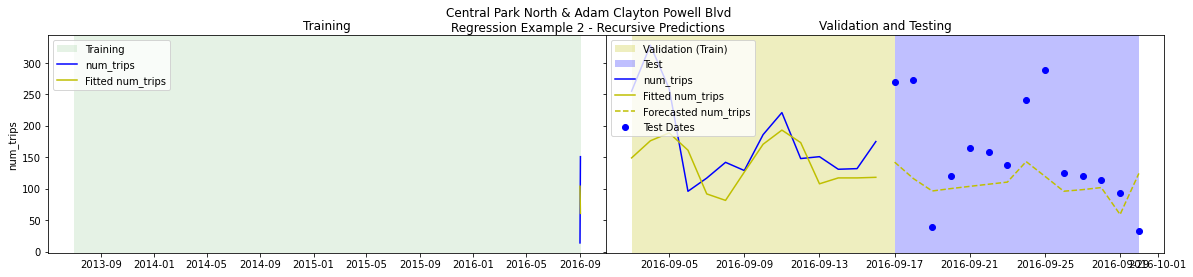

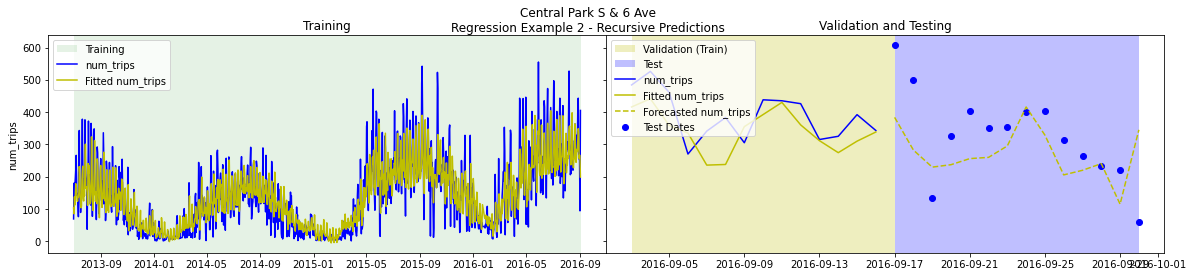

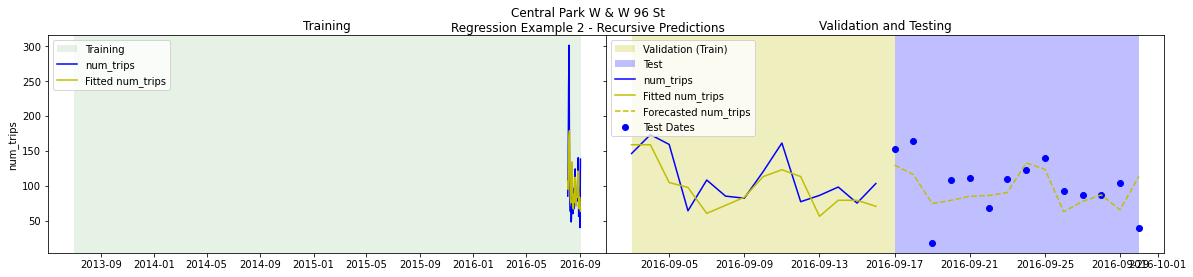

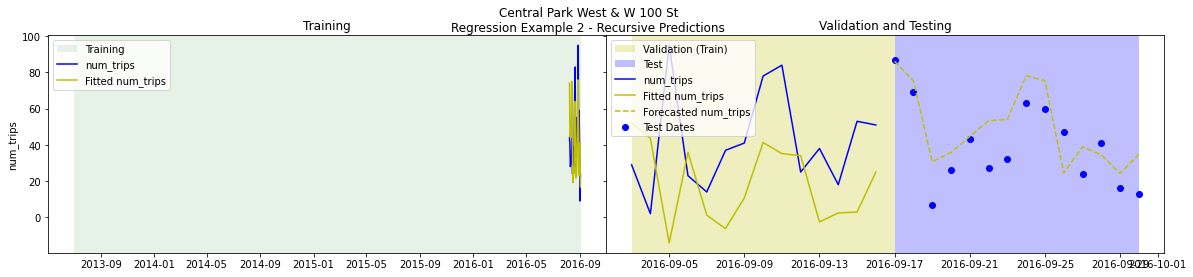

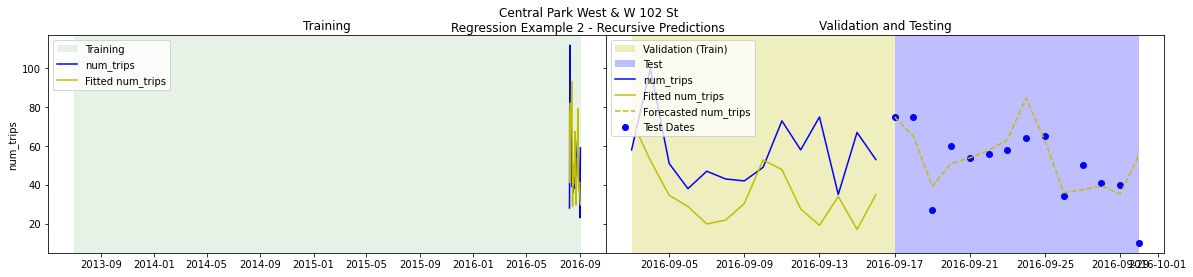

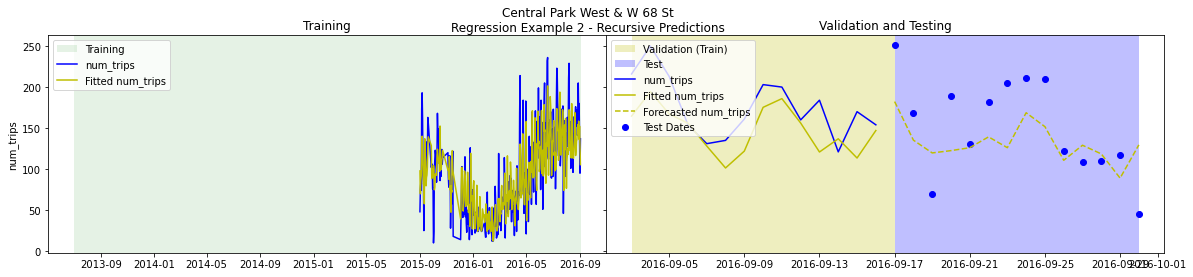

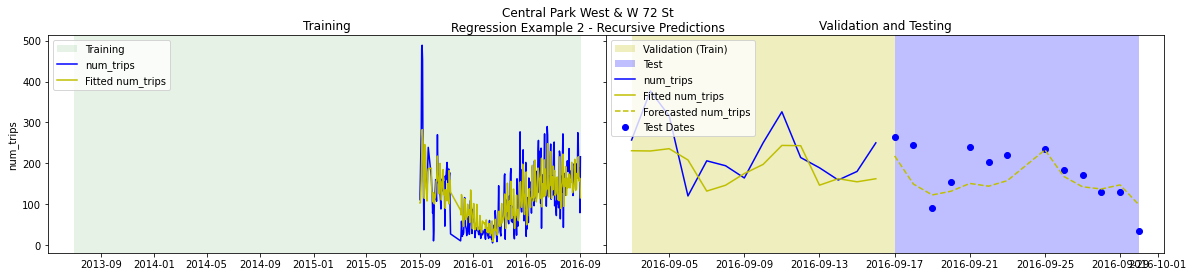

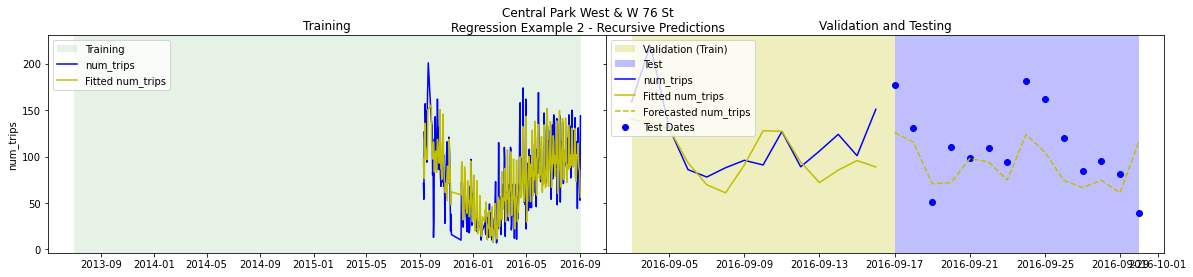

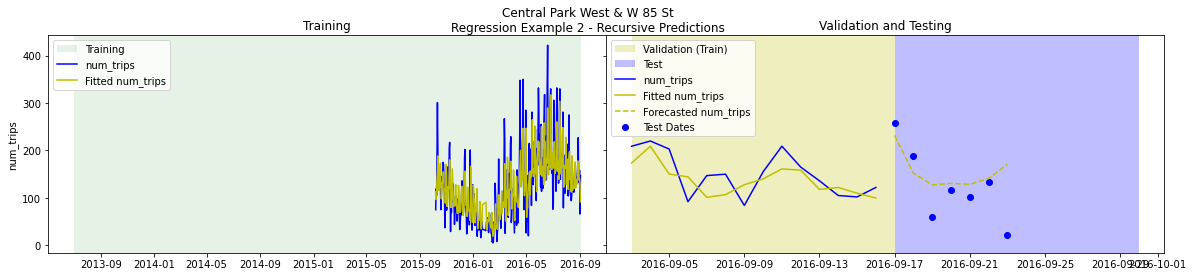

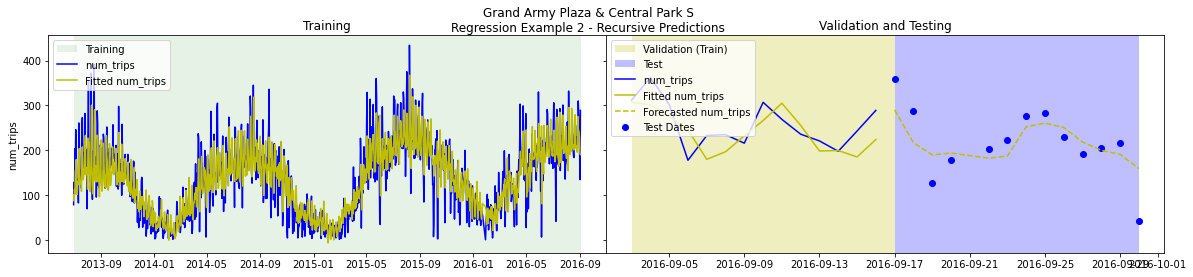

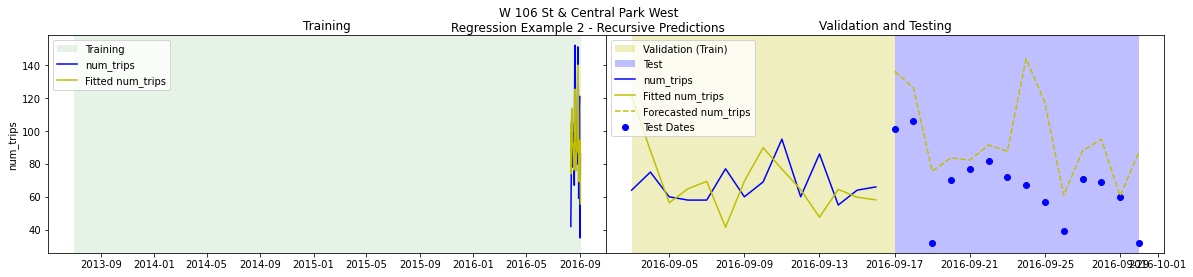

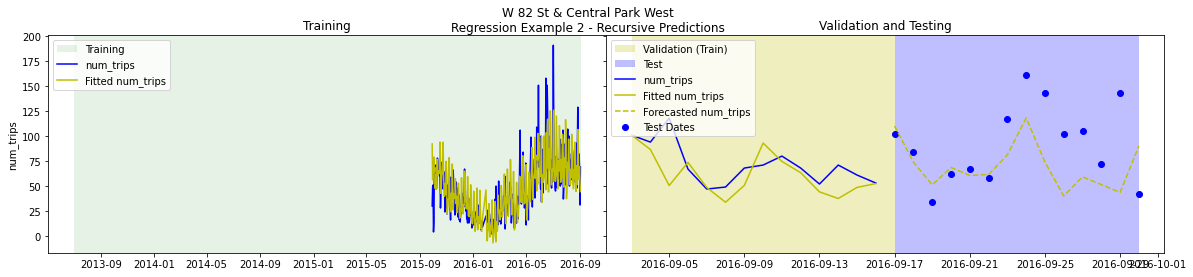

In [278]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]
        fit_traindf = pred_ex2[(pred_ex2[SERIES_COLUMN] == st) & (pred_ex2[TIME_COLUMN] < keyDates['val_start'][0])]
        fit_valdf = pred_ex2[(pred_ex2[SERIES_COLUMN] == st) & (pred_ex2[TIME_COLUMN] >= keyDates['val_start'][0]) & (pred_ex2[TIME_COLUMN] < keyDates['test_start'][0])]
        fit_testdf = pred_ex2[(pred_ex2[SERIES_COLUMN] == st) & (pred_ex2[TIME_COLUMN] >= keyDates['test_start'][0])]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
        #axes[1].fill_between(fit_testdf[TIME_COLUMN], fit_testdf['prediction_interval_lower_bound'], fit_testdf['prediction_interval_upper_bound'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        #axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        axes[0].plot(fit_traindf[TIME_COLUMN], fit_traindf['predicted'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_valdf[TIME_COLUMN], fit_valdf['predicted'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_testdf[TIME_COLUMN], fit_testdf['predicted'], color = 'y', label = f'Forecasted {TARGET_COLUMN}', linestyle='dashed')

        axes[1].scatter(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b', label = 'Test Dates')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st + f"\nRegression Example 2 - Recursive Predictions")

        # display result
        plt.show()

---
## Linear Regression - Example 3
- Multi-step Prediction - What is demand today (Ex 2 above)/tomorrow/next day/.../horizon based on
- Using Time Features: Week, Month, Year, Day, ...
- Using Lags for 1 day, 1 week (7), 1 month (28), 1 quarter (90), 1 year
- Using Leads each horizon day as targets for Multi-step models

**NOTE** Step 0 Model here is the same as Example 2 above

In [359]:
def make_model(LEAD):
    EX3_CTE = f"""
    WITH EX3_CTE AS (
        SELECT
            LEAD({TARGET_COLUMN}, {LEAD}) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) as {TARGET_COLUMN},
            {SERIES_COLUMN},
            splits,

            # TIME FEATURES
            EXTRACT(YEAR FROM {TIME_COLUMN}) AS Year,
            EXTRACT(MONTH FROM {TIME_COLUMN}) AS Month,
            EXTRACT(DAY FROM {TIME_COLUMN}) AS Day_of_Month,
            EXTRACT(DAYOFYEAR FROM {TIME_COLUMN}) AS Day_of_Year,
            EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) AS Day_of_Week,
            CASE WHEN EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) IN (1, 7) THEN 1 ELSE 0 END AS Weekend,

            # LAGs
            LAG({TARGET_COLUMN}, 1) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1day,
            LAG({TARGET_COLUMN}, 7) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1week,
            LAG({TARGET_COLUMN}, 28) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1month,
            LAG({TARGET_COLUMN}, 90) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1quarter,
            LAG({TARGET_COLUMN}, 365) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1year

        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    )
    """
    BQ_MODEL = f"{BQ_TABLE}_Regression_Example_3_STEP_{LEAD}"
    query = f"""
    CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
        OPTIONS (
            model_type = 'LINEAR_REG',
            input_label_cols = ['{TARGET_COLUMN}'],
            data_split_col = 'custom_splits',
            data_split_method = 'CUSTOM'
        ) AS
        {EX3_CTE}
        SELECT
            * EXCEPT(splits),
            CASE
                WHEN splits = 'TRAIN' THEN FALSE
                ELSE TRUE
            END AS custom_splits
        FROM EX3_CTE
        WHERE splits in ('TRAIN', 'VALIDATE')
            AND {TARGET_COLUMN} is not NUll
    """ 
    return BQ_MODEL, query

In [360]:
models = []
queries = []
horizon_length = (keyDates['end_date'].iloc[0] - keyDates['test_start'].iloc[0]).days + 1
for lead in range(horizon_length):
    model, query = make_model(lead)
    queries.append(query)
    models.append(model)
models

['forecasting-1_prepped_Regression_Example_3_STEP_0',
 'forecasting-1_prepped_Regression_Example_3_STEP_1',
 'forecasting-1_prepped_Regression_Example_3_STEP_2',
 'forecasting-1_prepped_Regression_Example_3_STEP_3',
 'forecasting-1_prepped_Regression_Example_3_STEP_4',
 'forecasting-1_prepped_Regression_Example_3_STEP_5',
 'forecasting-1_prepped_Regression_Example_3_STEP_6',
 'forecasting-1_prepped_Regression_Example_3_STEP_7',
 'forecasting-1_prepped_Regression_Example_3_STEP_8',
 'forecasting-1_prepped_Regression_Example_3_STEP_9',
 'forecasting-1_prepped_Regression_Example_3_STEP_10',
 'forecasting-1_prepped_Regression_Example_3_STEP_11',
 'forecasting-1_prepped_Regression_Example_3_STEP_12',
 'forecasting-1_prepped_Regression_Example_3_STEP_13']

In [361]:
jobs = []
for query in queries:
    jobs.append(bq.query(query = query))
    
while not all([job.done() for job in jobs]):
    print('waiting on all jobs to finish ... sleeping for 5s')
    sleep(5)
for j, job in enumerate(jobs):
    print('Completed with Errors = ', job.error_result, 'for ', queries[j].splitlines()[1])

waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
Completed with Errors =  None for      CREATE OR REPLACE MODEL `statmike-mlops-349915.applied_forecasting.forecasting-1_prepped_Regression_Example_3_STEP_0`
Completed with Errors =  None for      CREATE OR REPLACE MODEL `statmike-mlops-349915.applied_forecasting.forecasting-1_prepped_Regression_Example_3_STEP_1`
Completed with Errors =  None for      CREATE OR REPLACE MODEL `statmike-mlops-349915.applied_forecasting.forecasting-1_prepped_Regression_Example_3_STEP_2`
Completed with Errors =  None for      CREATE OR REPLACE MODEL `statmike-mlops-349915.applied_forecasting.forecasting-1_prepped_Regression_Example_3_STEP_3`
Completed with Errors =  None for      CREATE OR REPLACE MODEL `statmike-mlops-349915.applied_forecasting.forecasting-1_prepped_Regression_Example_3_STEP_4`
Completed with Errors =  None for      CREATE OR REPLACE MODEL `s

In [362]:
print(f'Direct link to the models in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{models[-1]}')

Direct link to the models in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sapplied_forecasting!3sforecasting-1_prepped_Regression_Example_3_STEP_13


In [363]:
for m, model in enumerate(models):
    if m == 0:
        query = f"""
            SELECT * FROM
            (SELECT processed_input, weight as step_{int(model.split('_')[-1])}_weight FROM ML.WEIGHTS (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{model}`))
        """
    else:
        query += f"""
            JOIN
            (SELECT processed_input, weight as step_{int(model.split('_')[-1])}_weight FROM ML.WEIGHTS (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{model}`))
            USING(processed_input)
        """
#print(query)

In [364]:
weights = bq.query(query = query).to_dataframe()
weights

processed_input  step_0_weight  step_1_weight  step_2_weight  \
0   start_station_name            NaN            NaN            NaN   
1                 Year       8.720551      13.899529      17.289394   
2                Month     314.911542     468.665403     463.555111   
3         Day_of_Month      10.473897      15.205164      14.993854   
4          Day_of_Year     -10.331099     -15.356417     -15.157509   
5          Day_of_Week       3.230271      10.951416       9.167385   
6              Weekend      23.500901      -0.615963     -36.115224   
7             lag_1day       0.446639       0.317889       0.293473   
8            lag_1week       0.222376       0.235801       0.201840   
9           lag_1month       0.161758       0.141870       0.139597   
10        lag_1quarter      -0.012539       0.011328      -0.036758   
11           lag_1year       0.105919       0.188289       0.226328   
12       __INTERCEPT__  -18583.465294  -26036.369362  -36412.661914   

    step_3_weight  step_4_weight  step_5_weight  step_6_weight  step_7_weight  \
0             NaN            NaN            NaN            NaN            NaN   
1       20.024908      20.476217      17.600391      15.613743      16.580810   
2      449.032839     523.509726     488.236301     473.974288     618.775511   
3       14.453794      16.945993      15.746722      15.253538      20.177821   
4      -14.658090     -17.116742     -15.986714     -15.547059     -20.330695   
5        4.261593       0.683236      -2.477372      -4.248118       1.969969   
6      -40.695806     -39.334751     -35.911354      -6.400233      20.251078   
7        0.223741       0.237433       0.363227       0.383763       0.245903   
8        0.216930       0.200089       0.190402       0.220719       0.299832   
9        0.151945       0.159792       0.120566       0.152678       0.210535   
10      -0.086450      -0.079823      -0.056568      -0.069362      -0.047603   
11       0.253612       0.225029       0.166198       0.137383       0.150668   
12  -43030.276742  -45684.071407  -40223.737225  -34919.594055  -37834.852173   

    step_8_weight  step_9_weight  step_10_weight  step_11_weight  \
0             NaN            NaN             NaN             NaN   
1       19.201072      21.844250       23.625299       23.805169   
2      704.886880     681.972959      670.852786      642.925251   
3       22.943184      22.027617       21.731057       20.899933   
4      -23.152852     -22.374667      -22.001151      -21.083762   
5       10.061106       8.404580        3.518038        0.467625   
6       -3.233317     -36.179932      -39.514871      -36.600273   
7        0.210316       0.242669        0.204775        0.236721   
8        0.289687       0.225308        0.207124        0.192522   
9        0.170251       0.128066        0.156432        0.135134   
10      -0.009785      -0.020461       -0.058035       -0.063727   
11       0.217650       0.263154        0.282481        0.268595   
12  -41928.756620  -50234.993021   -49826.805677   -46626.520730   

    step_12_weight  step_13_weight  
0              NaN             NaN  
1        20.983700       17.880881  
2       538.734736      445.999377  
3        17.539289       14.432787  
4       -17.676794      -14.656938  
5        -2.457550       -3.695366  
6       -32.025721       -3.655255  
7         0.367833        0.415595  
8         0.163356        0.217597  
9         0.106568        0.103840  
10       -0.067887       -0.072456  
11        0.193425        0.132888  
12   -45762.417003   -34283.478899

### Prediction with Multi-Step Model

There is a separate model for predicted each number of steps ahead up to the width of the horizon here: text horizon.

Using the input data from just before the test region as inputs, each model yields a prediction for a test day.

In [366]:
BQ_MODEL = f"{BQ_TABLE}_Regression_Example_3"

In [378]:
EX3_CTE = f"""
WITH
    EX3_CTE AS (
        SELECT
            {TARGET_COLUMN},
            {SERIES_COLUMN},
            splits,

            # TIME FEATURES
            EXTRACT(YEAR FROM {TIME_COLUMN}) AS Year,
            EXTRACT(MONTH FROM {TIME_COLUMN}) AS Month,
            EXTRACT(DAY FROM {TIME_COLUMN}) AS Day_of_Month,
            EXTRACT(DAYOFYEAR FROM {TIME_COLUMN}) AS Day_of_Year,
            EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) AS Day_of_Week,
            CASE WHEN EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) IN (1, 7) THEN 1 ELSE 0 END AS Weekend,

            # LAGs
            LAG({TARGET_COLUMN}, 1) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1day,
            LAG({TARGET_COLUMN}, 7) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1week,
            LAG({TARGET_COLUMN}, 28) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1month,
            LAG({TARGET_COLUMN}, 90) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1quarter,
            LAG({TARGET_COLUMN}, 365) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1year,
            
            # number days
            ROW_NUMBER() OVER(PARTITION BY {SERIES_COLUMN}, splits ORDER BY {TIME_COLUMN}) as horizon_day

        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`  
    )
"""

In [386]:
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA` AS
{EX3_CTE}
SELECT * FROM
(SELECT * EXCEPT(splits, lag_1day, lag_1week, lag_1month, lag_1quarter, lag_1year) FROM EX3_CTE WHERE splits = 'TEST')
LEFT OUTER JOIN
(SELECT {SERIES_COLUMN}, lag_1day, lag_1week, lag_1month, lag_1quarter, lag_1year FROM EX3_CTE WHERE splits='TEST' and horizon_day = 1)
USING ({SERIES_COLUMN})
ORDER BY {SERIES_COLUMN}, Year, Month, Day_of_Month
"""
job = bq.query(query = query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 2.143


Directly predict each day of the horizon with the corresponding model from the multi-step model:

In [387]:
models

['forecasting-1_prepped_Regression_Example_3_STEP_0',
 'forecasting-1_prepped_Regression_Example_3_STEP_1',
 'forecasting-1_prepped_Regression_Example_3_STEP_2',
 'forecasting-1_prepped_Regression_Example_3_STEP_3',
 'forecasting-1_prepped_Regression_Example_3_STEP_4',
 'forecasting-1_prepped_Regression_Example_3_STEP_5',
 'forecasting-1_prepped_Regression_Example_3_STEP_6',
 'forecasting-1_prepped_Regression_Example_3_STEP_7',
 'forecasting-1_prepped_Regression_Example_3_STEP_8',
 'forecasting-1_prepped_Regression_Example_3_STEP_9',
 'forecasting-1_prepped_Regression_Example_3_STEP_10',
 'forecasting-1_prepped_Regression_Example_3_STEP_11',
 'forecasting-1_prepped_Regression_Example_3_STEP_12',
 'forecasting-1_prepped_Regression_Example_3_STEP_13']

In [388]:
# PREDICTIONS FOR FIRST DAY OF HORIZON - Uses Example 2 Above
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_DIRECT` AS
    SELECT *
    FROM ML.PREDICT (
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{models[0]}`,
        (
            SELECT *
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA`
            WHERE horizon_day = 1
        )
    )
"""
job = bq.query(query = query)
job.result()

query = f"""
SELECT column_name
FROM `{BQ_PROJECT}.{BQ_DATASET}.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = '{BQ_MODEL}_TEST_DATA_DIRECT'
"""
columns_in_order = ', '.join(list(bq.query(query).to_dataframe()['column_name']))

# PREDICTION FOR SECOND DAY OF HORIZON (1) TO LAST DAY OF HORIZON
horizon_length = (keyDates['end_date'].iloc[0] - keyDates['test_start'].iloc[0]).days + 1
for day in range(1, horizon_length):
    query = f"""
    INSERT INTO `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_DIRECT`
        SELECT {columns_in_order}
        FROM  ML.PREDICT (
            MODEL `{BQ_PROJECT}.{BQ_DATASET}.{models[day]}`,
            (
                SELECT *
                FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA`
                WHERE horizon_day = {day+1}
            )
        )
    """
    job = bq.query(query = query)
    job.result()

### Custom Evaluation Metrics

Since the Test region is being predicted using an ensemble of the multi-step models it is easier to customer calculate the metrics using SQL:

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divided by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$
- MSE, or Mean Squared Error
    - $\textrm{MSE} = \frac{1}{n}\sum{(actual-forecast)^2}$
- RMSE, or Root Mean Squared Error
    - $\textrm{RMSE} = \sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}$
- RMSE divided by average demand so it yeilds a % like MAPE
    - $\textrm{pRMSE} = \frac{\sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}}{\frac{1}{n}\sum{actual}}$


In [390]:
query = f"""
    WITH
        DIFFS AS (
            SELECT {SERIES_COLUMN},  
                {TARGET_COLUMN} as actual_value,
                predicted_{TARGET_COLUMN} as forecast_value, 
                ({TARGET_COLUMN} - predicted_{TARGET_COLUMN}) as diff
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_DIRECT`
        )
    SELECT #{SERIES_COLUMN}, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    #GROUP BY {SERIES_COLUMN}
    #ORDER BY {SERIES_COLUMN}    
"""
customMetrics = bq.query(query = query).to_dataframe()
customMetrics

MAPE        MAE      pMAE          MSE      RMSE     pRMSE
0  0.58399  49.120601  0.366761  4995.728838  70.68047  0.527739

In [391]:
query = f"""
SELECT
    {SERIES_COLUMN},
    DATE(year, month, day_of_month) AS {TIME_COLUMN},
    predicted_{TARGET_COLUMN} AS predicted
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_DIRECT`
ORDER BY Year, Month, Day_of_Month
"""
pred_ex3 = bq.query(query = query).to_dataframe()

In [392]:
pred_ex3

start_station_name   starttime   predicted
0                     W 106 St & Central Park West  2016-09-17  100.232926
1                     Central Park West & W 100 St  2016-09-17   63.980219
2                         Central Park W & W 96 St  2016-09-17  125.402702
3                     Central Park West & W 102 St  2016-09-17   58.041816
4    Central Park North & Adam Clayton Powell Blvd  2016-09-17  176.949656
..                                             ...         ...         ...
154                    W 82 St & Central Park West  2016-09-30   36.570979
155                    Central Park West & W 68 St  2016-09-30  121.860804
156                         Central Park S & 6 Ave  2016-09-30  313.663009
157              Grand Army Plaza & Central Park S  2016-09-30  258.937548
158                    Central Park West & W 72 St  2016-09-30  178.216635

[159 rows x 3 columns]

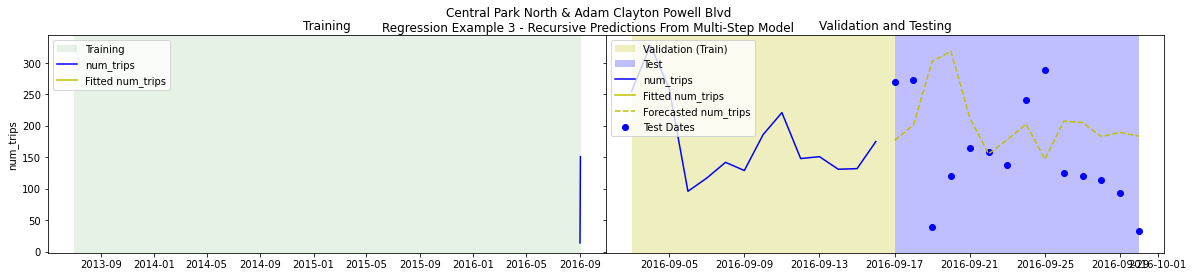

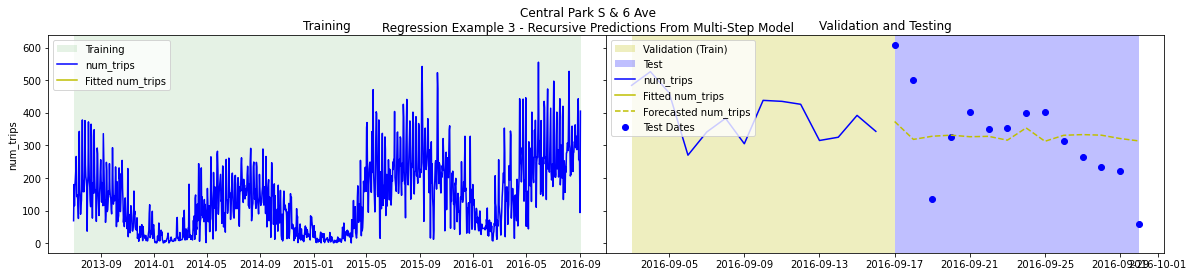

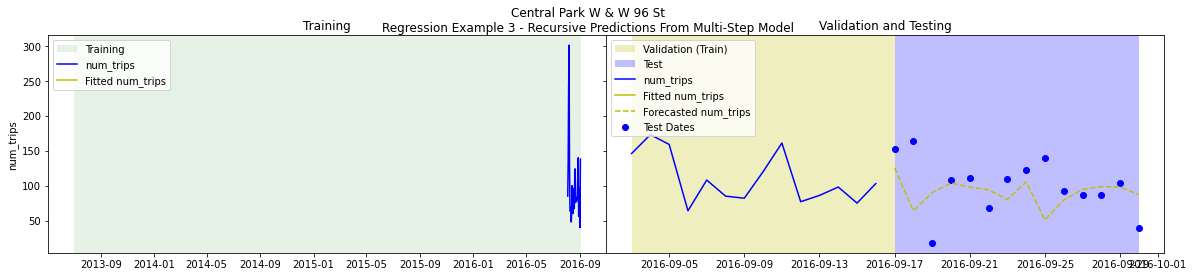

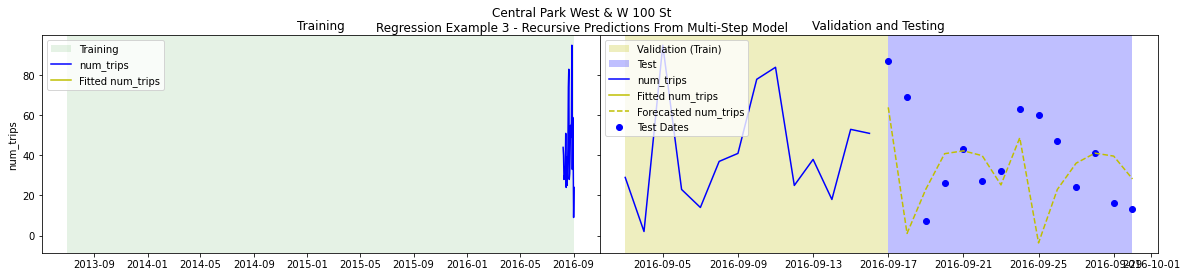

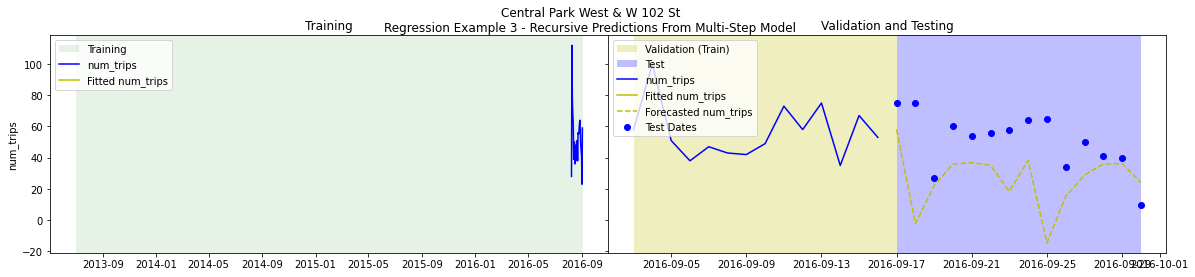

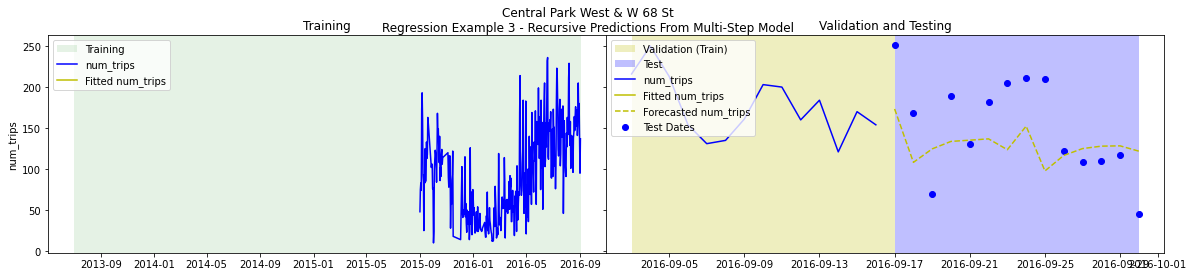

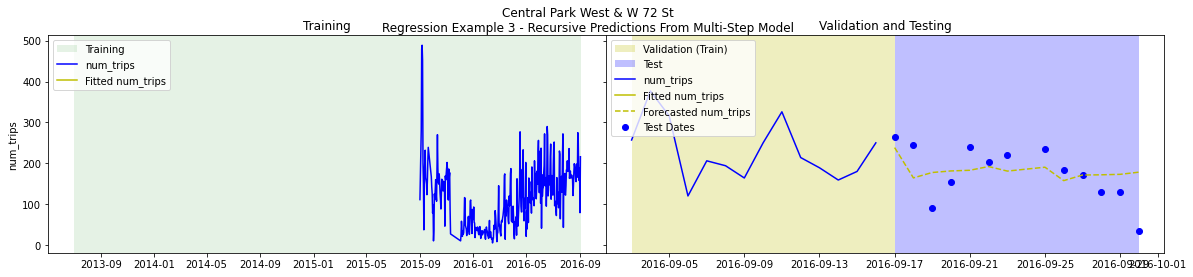

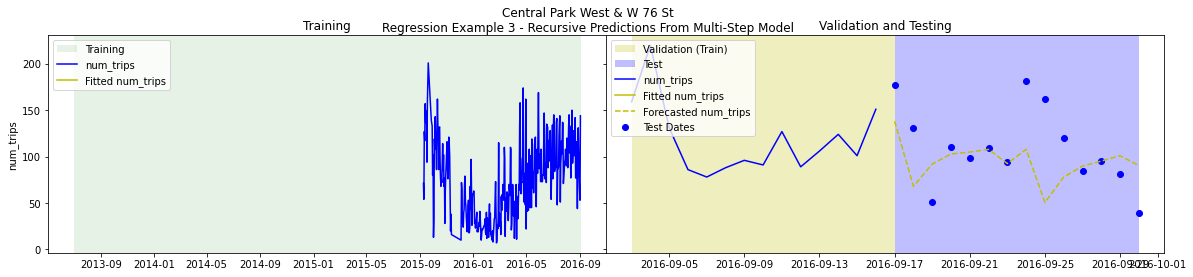

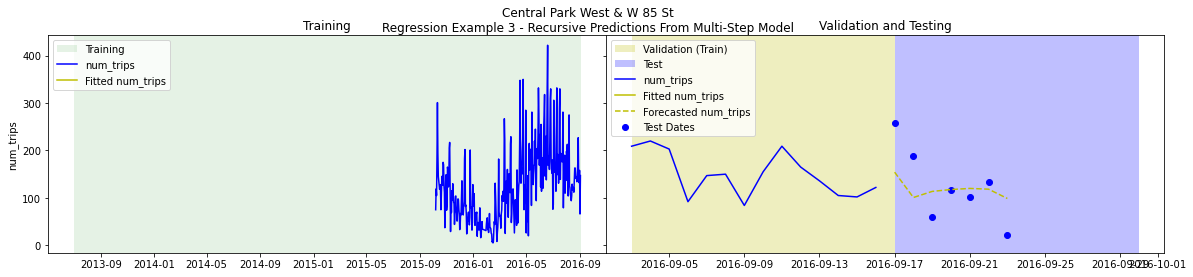

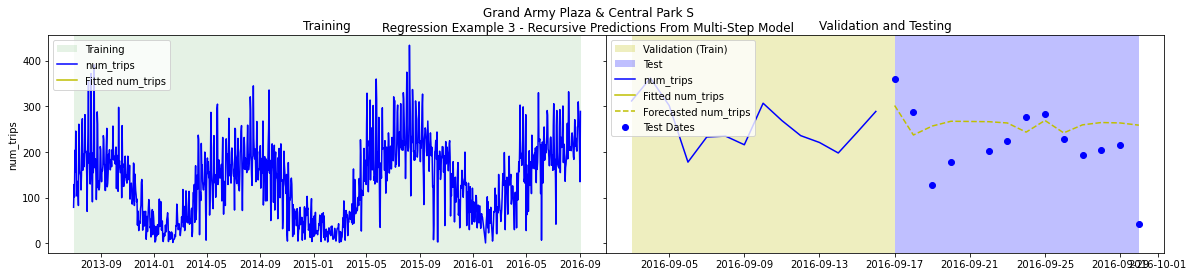

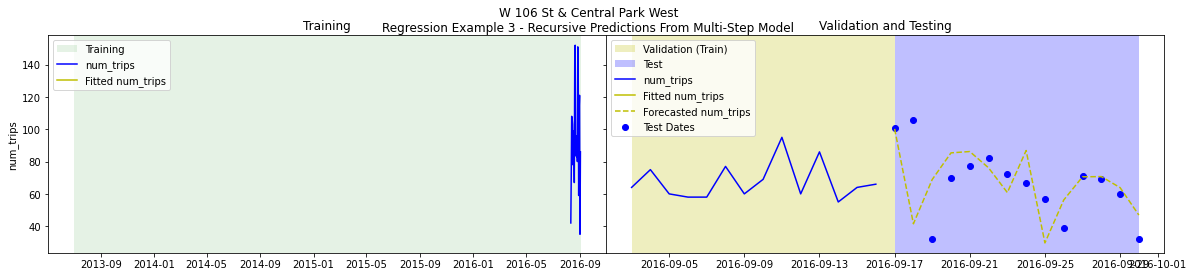

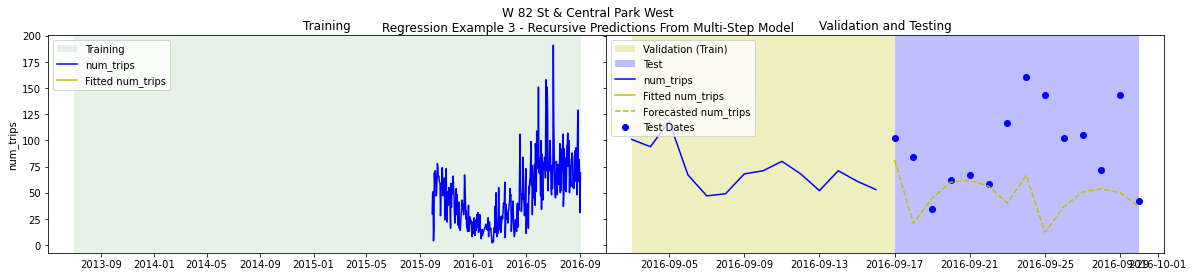

In [393]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]
        fit_traindf = pred_ex3[(pred_ex3[SERIES_COLUMN] == st) & (pred_ex3[TIME_COLUMN] < keyDates['val_start'][0])]
        fit_valdf = pred_ex3[(pred_ex3[SERIES_COLUMN] == st) & (pred_ex3[TIME_COLUMN] >= keyDates['val_start'][0]) & (pred_ex3[TIME_COLUMN] < keyDates['test_start'][0])]
        fit_testdf = pred_ex3[(pred_ex3[SERIES_COLUMN] == st) & (pred_ex3[TIME_COLUMN] >= keyDates['test_start'][0])]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
        #axes[1].fill_between(fit_testdf[TIME_COLUMN], fit_testdf['prediction_interval_lower_bound'], fit_testdf['prediction_interval_upper_bound'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        #axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        axes[0].plot(fit_traindf[TIME_COLUMN], fit_traindf['predicted'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_valdf[TIME_COLUMN], fit_valdf['predicted'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_testdf[TIME_COLUMN], fit_testdf['predicted'], color = 'y', label = f'Forecasted {TARGET_COLUMN}', linestyle='dashed')

        axes[1].scatter(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b', label = 'Test Dates')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st + f"\nRegression Example 3 - Recursive Predictions From Multi-Step Model")

        # display result
        plt.show()

---
## Boosted Tree Regressor - Example 4
- Multi-step Prediction - What is demand today/tomorrow/next day/.../horizon based on
- Using Time Features: Week, Month, Year, Day, ...
- Using Lags for 1 day, 1 week (7), 1 month (28), 1 quarter (90), 1 year
- Using Leads each horizon day as targets for Multi-step models

In [395]:
def make_model(LEAD):
    EX4_CTE = f"""
    WITH EX4_CTE AS (
        SELECT
            LEAD({TARGET_COLUMN}, {LEAD}) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) as {TARGET_COLUMN},
            {SERIES_COLUMN},
            splits,

            # TIME FEATURES
            EXTRACT(YEAR FROM {TIME_COLUMN}) AS Year,
            EXTRACT(MONTH FROM {TIME_COLUMN}) AS Month,
            EXTRACT(DAY FROM {TIME_COLUMN}) AS Day_of_Month,
            EXTRACT(DAYOFYEAR FROM {TIME_COLUMN}) AS Day_of_Year,
            EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) AS Day_of_Week,
            CASE WHEN EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) IN (1, 7) THEN 1 ELSE 0 END AS Weekend,

            # LAGs
            LAG({TARGET_COLUMN}, 1) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1day,
            LAG({TARGET_COLUMN}, 7) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1week,
            LAG({TARGET_COLUMN}, 28) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1month,
            LAG({TARGET_COLUMN}, 90) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1quarter,
            LAG({TARGET_COLUMN}, 365) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1year

        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    )
    """
    BQ_MODEL = f"{BQ_TABLE}_Regression_Example_4_STEP_{LEAD}"
    query = f"""
    CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
        OPTIONS (
            model_type = 'BOOSTED_TREE_REGRESSOR',
            input_label_cols = ['{TARGET_COLUMN}'],
            data_split_col = 'custom_splits',
            data_split_method = 'CUSTOM',
            booster_type = 'GBTREE',
            num_parallel_tree = 1,
            max_iterations = 30,
            early_stop = TRUE,
            min_rel_progress = 0.01,
            tree_method = 'HIST',
            subsample = 0.85
        ) AS
        {EX3_CTE}
        SELECT
            * EXCEPT(splits),
            CASE
                WHEN splits = 'TRAIN' THEN FALSE
                ELSE TRUE
            END AS custom_splits
        FROM EX3_CTE
        WHERE splits in ('TRAIN', 'VALIDATE')
            AND {TARGET_COLUMN} is not NUll
    """ 
    return BQ_MODEL, query

In [396]:
models = []
queries = []
horizon_length = (keyDates['end_date'].iloc[0] - keyDates['test_start'].iloc[0]).days + 1
for lead in range(horizon_length):
    model, query = make_model(lead)
    queries.append(query)
    models.append(model)
models

['forecasting-1_prepped_Regression_Example_4_STEP_0',
 'forecasting-1_prepped_Regression_Example_4_STEP_1',
 'forecasting-1_prepped_Regression_Example_4_STEP_2',
 'forecasting-1_prepped_Regression_Example_4_STEP_3',
 'forecasting-1_prepped_Regression_Example_4_STEP_4',
 'forecasting-1_prepped_Regression_Example_4_STEP_5',
 'forecasting-1_prepped_Regression_Example_4_STEP_6',
 'forecasting-1_prepped_Regression_Example_4_STEP_7',
 'forecasting-1_prepped_Regression_Example_4_STEP_8',
 'forecasting-1_prepped_Regression_Example_4_STEP_9',
 'forecasting-1_prepped_Regression_Example_4_STEP_10',
 'forecasting-1_prepped_Regression_Example_4_STEP_11',
 'forecasting-1_prepped_Regression_Example_4_STEP_12',
 'forecasting-1_prepped_Regression_Example_4_STEP_13']

In [337]:
jobs = []
for query in queries:
    jobs.append(bq.query(query = query))
    
while not all([job.done() for job in jobs]):
    print('waiting on all jobs to finish ... sleeping for 5s')
    sleep(5)
for j, job in enumerate(jobs):
    print('Completed with Errors = ', job.error_result, 'for ', queries[j].splitlines()[1])

waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s
waiting on all jobs to finish ... sleeping for 5s


In [397]:
print(f'Direct link to the models in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{models[-1]}')

Direct link to the models in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sapplied_forecasting!3sforecasting-1_prepped_Regression_Example_4_STEP_13


### Prediction with Multi-Step Model

There is a separate model for predicted each number of steps ahead up to the width of the horizon here: text horizon.

Using the input data from just before the test region as inputs, each model yields a prediction for a test day.

In [398]:
BQ_MODEL = f"{BQ_TABLE}_Regression_Example_4"

In [399]:
EX4_CTE = f"""
WITH
    EX4_CTE AS (
        SELECT
            {TARGET_COLUMN},
            {SERIES_COLUMN},
            splits,

            # TIME FEATURES
            EXTRACT(YEAR FROM {TIME_COLUMN}) AS Year,
            EXTRACT(MONTH FROM {TIME_COLUMN}) AS Month,
            EXTRACT(DAY FROM {TIME_COLUMN}) AS Day_of_Month,
            EXTRACT(DAYOFYEAR FROM {TIME_COLUMN}) AS Day_of_Year,
            EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) AS Day_of_Week,
            CASE WHEN EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) IN (1, 7) THEN 1 ELSE 0 END AS Weekend,

            # LAGs
            LAG({TARGET_COLUMN}, 1) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1day,
            LAG({TARGET_COLUMN}, 7) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1week,
            LAG({TARGET_COLUMN}, 28) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1month,
            LAG({TARGET_COLUMN}, 90) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1quarter,
            LAG({TARGET_COLUMN}, 365) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1year,
            
            # number days
            ROW_NUMBER() OVER(PARTITION BY {SERIES_COLUMN}, splits ORDER BY {TIME_COLUMN}) as horizon_day

        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`  
    )
"""

In [400]:
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA` AS
{EX4_CTE}
SELECT * FROM
(SELECT * EXCEPT(splits, lag_1day, lag_1week, lag_1month, lag_1quarter, lag_1year) FROM EX4_CTE WHERE splits = 'TEST')
LEFT OUTER JOIN
(SELECT {SERIES_COLUMN}, lag_1day, lag_1week, lag_1month, lag_1quarter, lag_1year FROM EX4_CTE WHERE splits='TEST' and horizon_day = 1)
USING ({SERIES_COLUMN})
ORDER BY {SERIES_COLUMN}, Year, Month, Day_of_Month
"""
job = bq.query(query = query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 1.963


Directly predict each day of the horizon with the corresponding model from the multi-step model:

In [401]:
models

['forecasting-1_prepped_Regression_Example_4_STEP_0',
 'forecasting-1_prepped_Regression_Example_4_STEP_1',
 'forecasting-1_prepped_Regression_Example_4_STEP_2',
 'forecasting-1_prepped_Regression_Example_4_STEP_3',
 'forecasting-1_prepped_Regression_Example_4_STEP_4',
 'forecasting-1_prepped_Regression_Example_4_STEP_5',
 'forecasting-1_prepped_Regression_Example_4_STEP_6',
 'forecasting-1_prepped_Regression_Example_4_STEP_7',
 'forecasting-1_prepped_Regression_Example_4_STEP_8',
 'forecasting-1_prepped_Regression_Example_4_STEP_9',
 'forecasting-1_prepped_Regression_Example_4_STEP_10',
 'forecasting-1_prepped_Regression_Example_4_STEP_11',
 'forecasting-1_prepped_Regression_Example_4_STEP_12',
 'forecasting-1_prepped_Regression_Example_4_STEP_13']

In [402]:
# PREDICTIONS FOR FIRST DAY OF HORIZON - Uses Example 2 Above
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_DIRECT` AS
    SELECT *
    FROM ML.PREDICT (
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{models[0]}`,
        (
            SELECT *
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA`
            WHERE horizon_day = 1
        )
    )
"""
job = bq.query(query = query)
job.result()

query = f"""
SELECT column_name
FROM `{BQ_PROJECT}.{BQ_DATASET}.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = '{BQ_MODEL}_TEST_DATA_DIRECT'
"""
columns_in_order = ', '.join(list(bq.query(query).to_dataframe()['column_name']))

# PREDICTION FOR SECOND DAY OF HORIZON (1) TO LAST DAY OF HORIZON
horizon_length = (keyDates['end_date'].iloc[0] - keyDates['test_start'].iloc[0]).days + 1
for day in range(1, horizon_length):
    query = f"""
    INSERT INTO `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_DIRECT`
        SELECT {columns_in_order}
        FROM  ML.PREDICT (
            MODEL `{BQ_PROJECT}.{BQ_DATASET}.{models[day]}`,
            (
                SELECT *
                FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA`
                WHERE horizon_day = {day+1}
            )
        )
    """
    job = bq.query(query = query)
    job.result()

### Custom Evaluation Metrics

Since the Test region is being predicted using an ensemble of the multi-step models it is easier to customer calculate the metrics using SQL:

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divided by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$
- MSE, or Mean Squared Error
    - $\textrm{MSE} = \frac{1}{n}\sum{(actual-forecast)^2}$
- RMSE, or Root Mean Squared Error
    - $\textrm{RMSE} = \sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}$
- RMSE divided by average demand so it yeilds a % like MAPE
    - $\textrm{pRMSE} = \frac{\sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}}{\frac{1}{n}\sum{actual}}$


In [403]:
query = f"""
    WITH
        DIFFS AS (
            SELECT {SERIES_COLUMN},  
                {TARGET_COLUMN} as actual_value,
                predicted_{TARGET_COLUMN} as forecast_value, 
                ({TARGET_COLUMN} - predicted_{TARGET_COLUMN}) as diff
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_DIRECT`
        )
    SELECT #{SERIES_COLUMN}, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    #GROUP BY {SERIES_COLUMN}
    #ORDER BY {SERIES_COLUMN}    
"""
customMetrics = bq.query(query = query).to_dataframe()
customMetrics

MAPE       MAE      pMAE          MSE       RMSE     pRMSE
0  0.610984  42.40862  0.316646  3748.423752  61.224372  0.457134

In [404]:
query = f"""
SELECT
    {SERIES_COLUMN},
    DATE(year, month, day_of_month) AS {TIME_COLUMN},
    predicted_{TARGET_COLUMN} AS predicted
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_DIRECT`
ORDER BY Year, Month, Day_of_Month
"""
pred_ex4 = bq.query(query = query).to_dataframe()

In [405]:
pred_ex4

start_station_name   starttime   predicted
0                     Central Park West & W 102 St  2016-09-17   71.421181
1                     Central Park West & W 100 St  2016-09-17   70.192978
2                     W 106 St & Central Park West  2016-09-17   80.593811
3                         Central Park W & W 96 St  2016-09-17  130.033432
4    Central Park North & Adam Clayton Powell Blvd  2016-09-17  192.981430
..                                             ...         ...         ...
154                       Central Park W & W 96 St  2016-09-30  100.642448
155                    Central Park West & W 76 St  2016-09-30  124.904968
156                    W 82 St & Central Park West  2016-09-30   56.463490
157                    Central Park West & W 68 St  2016-09-30  154.593796
158                         Central Park S & 6 Ave  2016-09-30  218.979080

[159 rows x 3 columns]

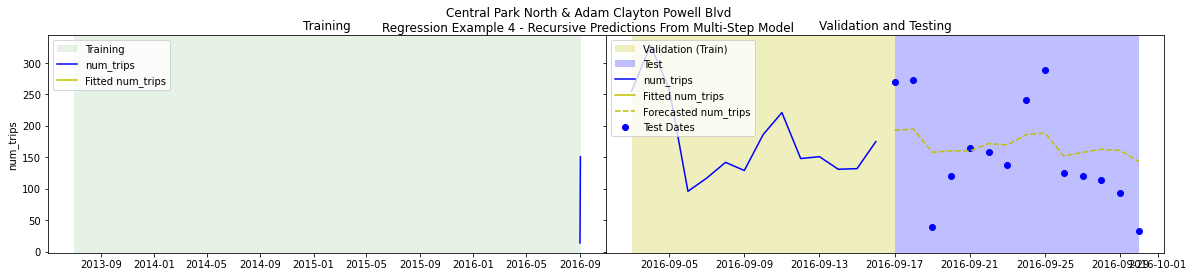

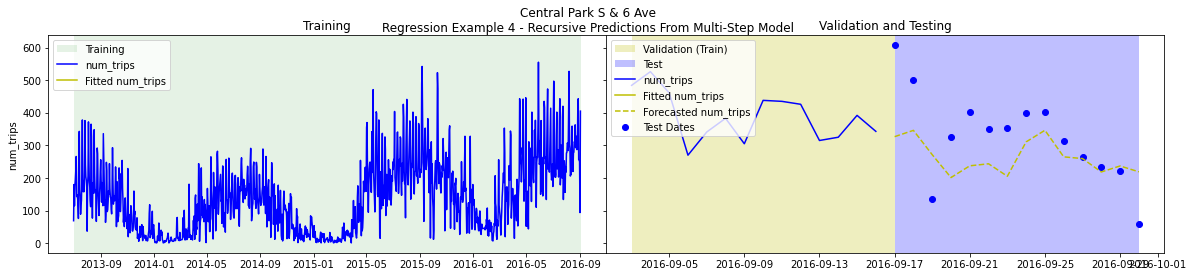

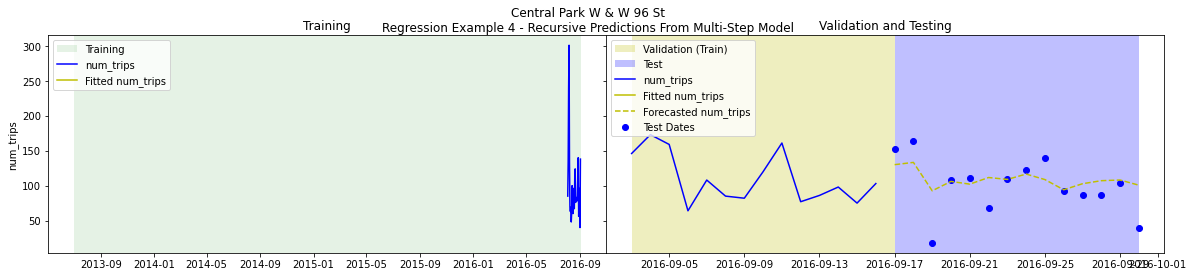

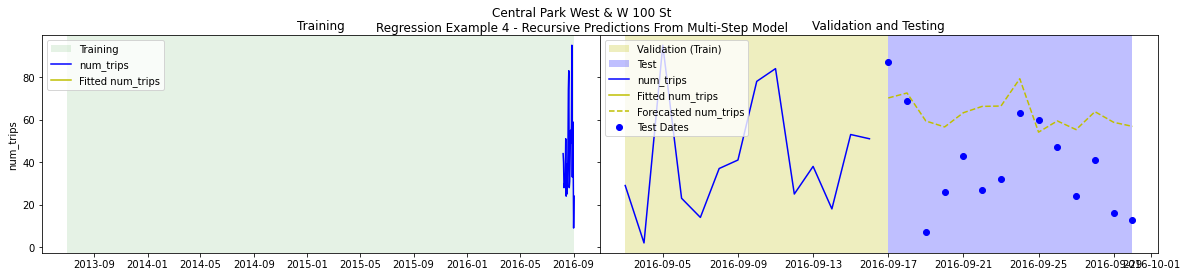

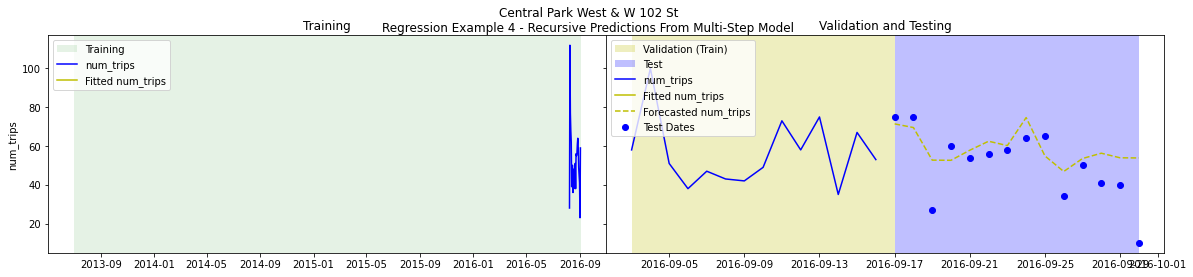

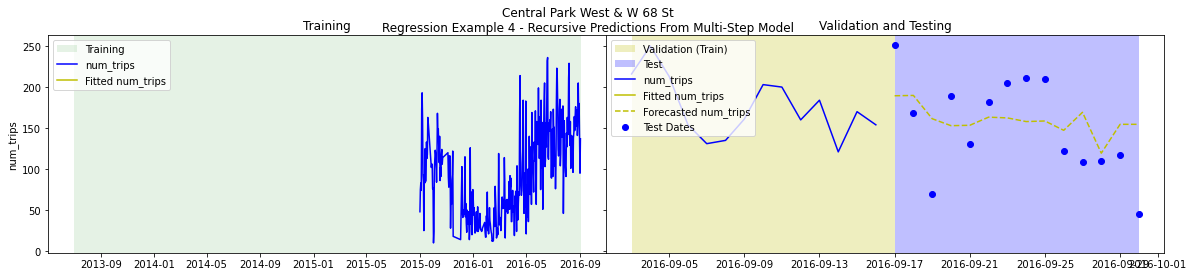

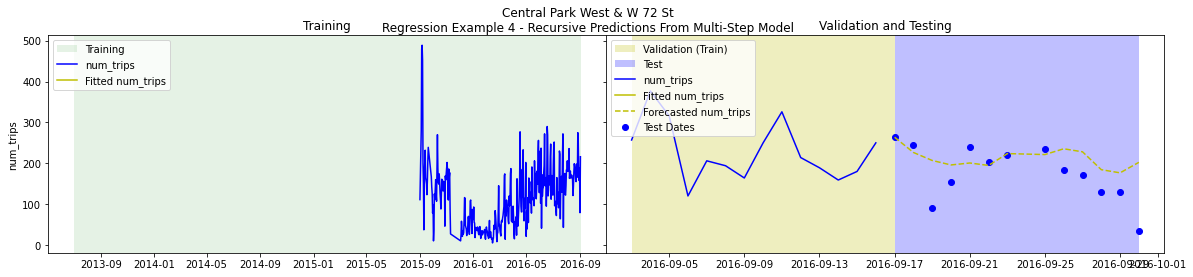

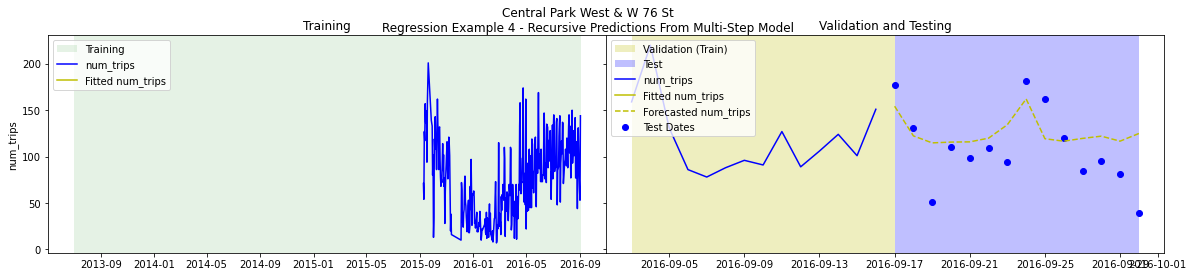

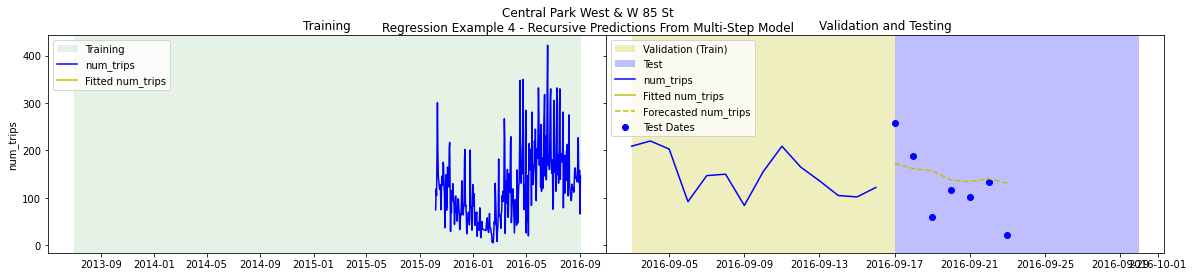

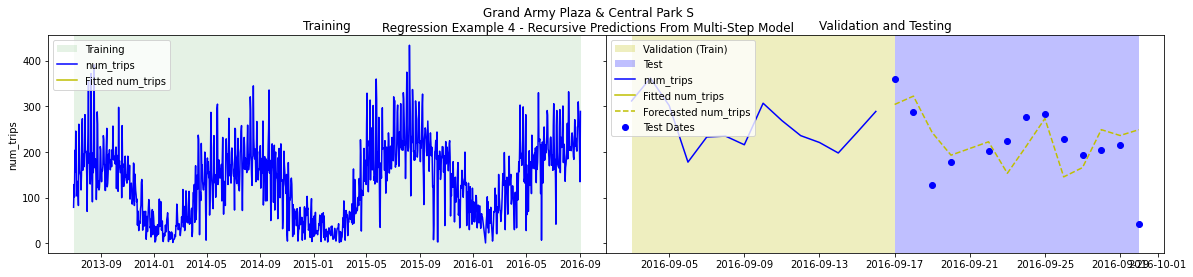

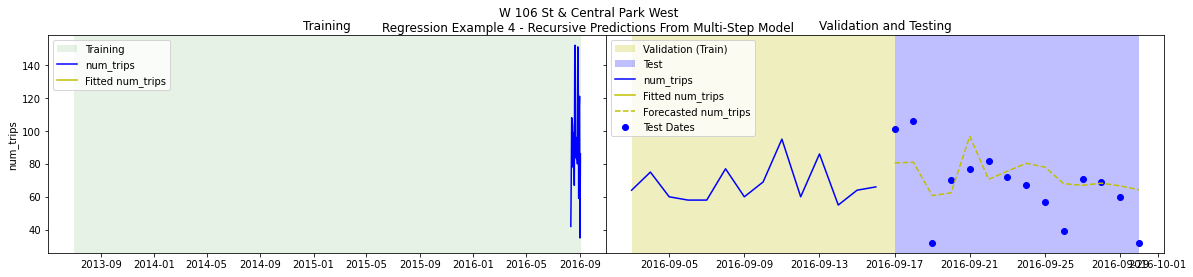

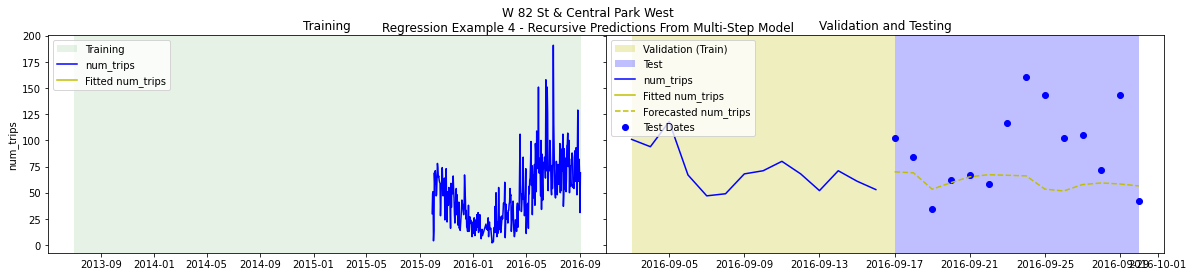

In [406]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]
        fit_traindf = pred_ex4[(pred_ex4[SERIES_COLUMN] == st) & (pred_ex4[TIME_COLUMN] < keyDates['val_start'][0])]
        fit_valdf = pred_ex4[(pred_ex4[SERIES_COLUMN] == st) & (pred_ex4[TIME_COLUMN] >= keyDates['val_start'][0]) & (pred_ex4[TIME_COLUMN] < keyDates['test_start'][0])]
        fit_testdf = pred_ex4[(pred_ex4[SERIES_COLUMN] == st) & (pred_ex4[TIME_COLUMN] >= keyDates['test_start'][0])]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
        #axes[1].fill_between(fit_testdf[TIME_COLUMN], fit_testdf['prediction_interval_lower_bound'], fit_testdf['prediction_interval_upper_bound'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        #axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        axes[0].plot(fit_traindf[TIME_COLUMN], fit_traindf['predicted'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_valdf[TIME_COLUMN], fit_valdf['predicted'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_testdf[TIME_COLUMN], fit_testdf['predicted'], color = 'y', label = f'Forecasted {TARGET_COLUMN}', linestyle='dashed')

        axes[1].scatter(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b', label = 'Test Dates')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st + f"\nRegression Example 4 - Recursive Predictions From Multi-Step Model")

        # display result
        plt.show()

## Comparison

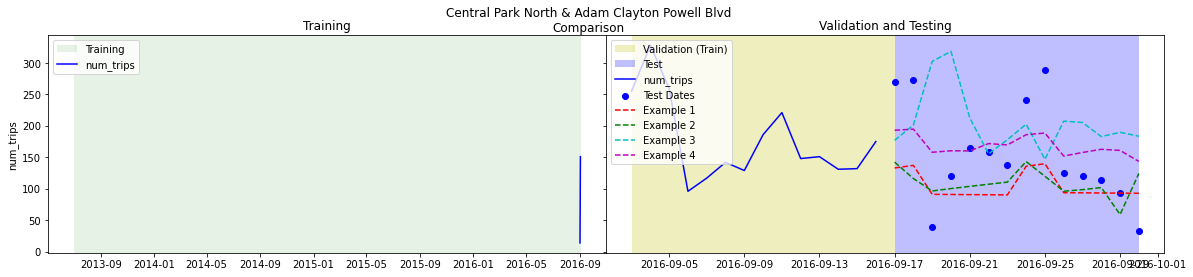

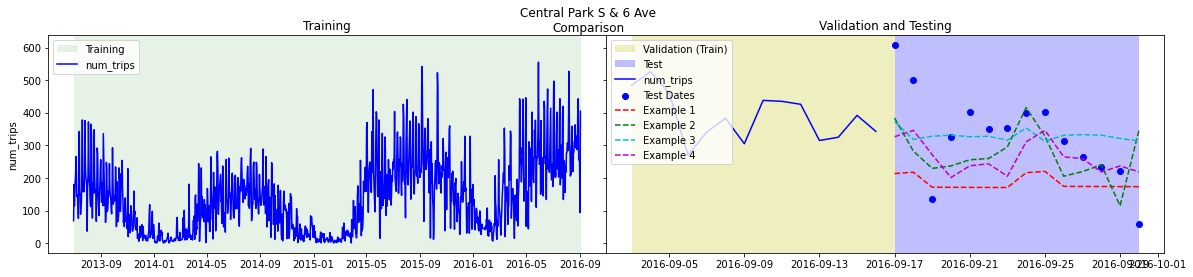

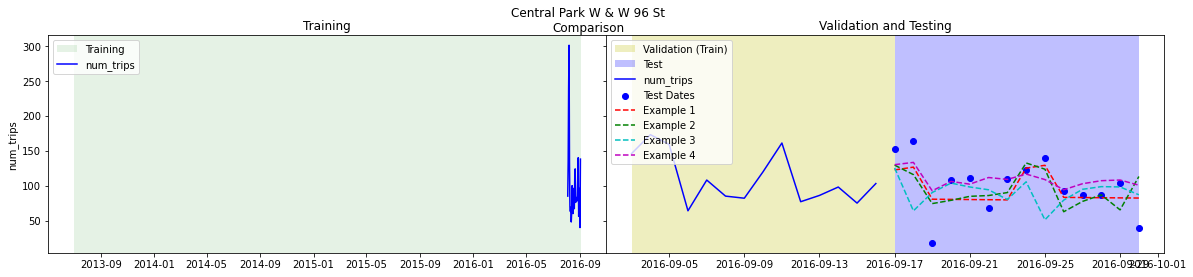

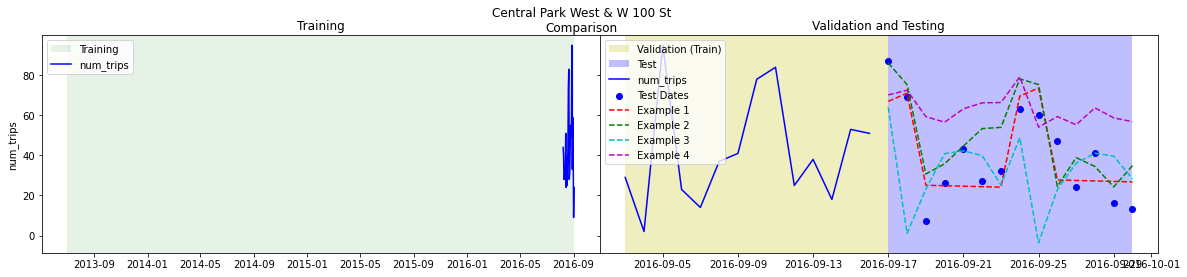

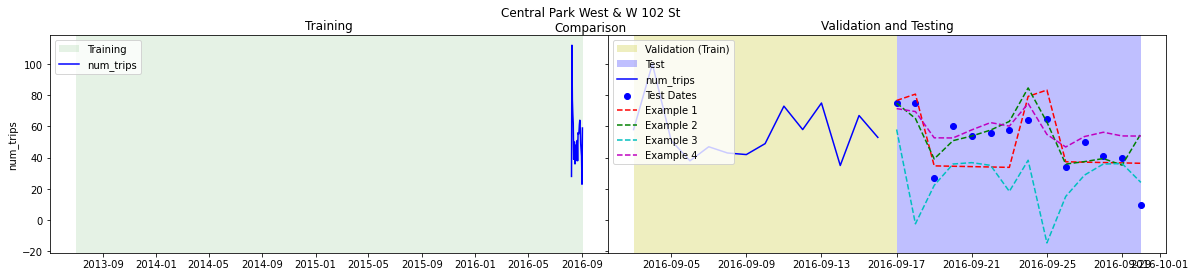

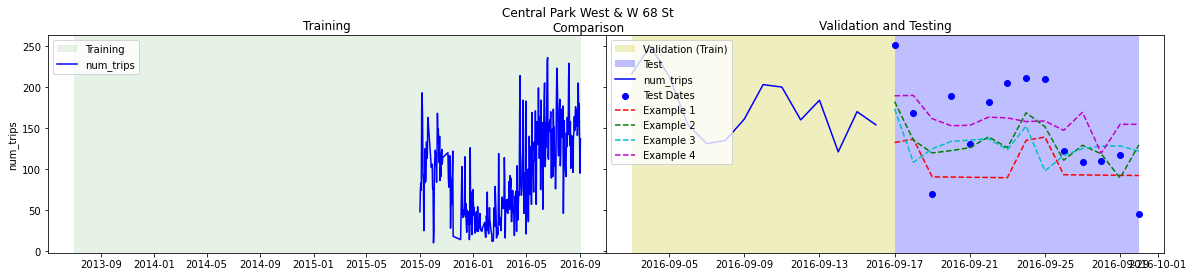

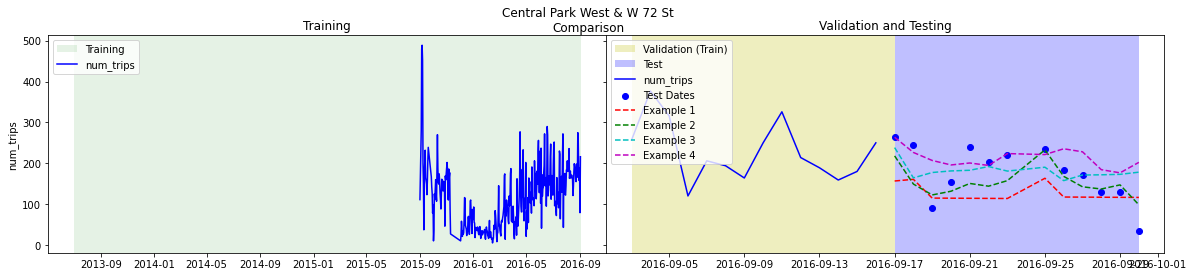

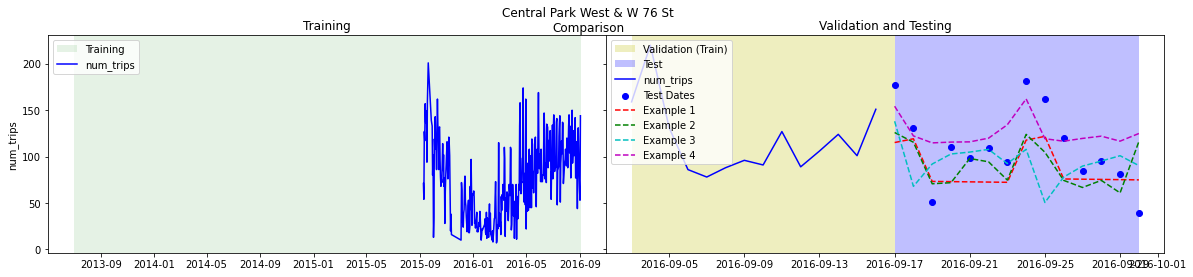

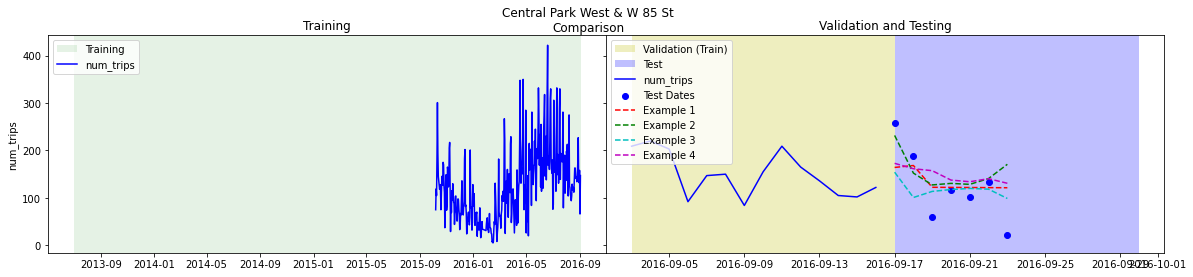

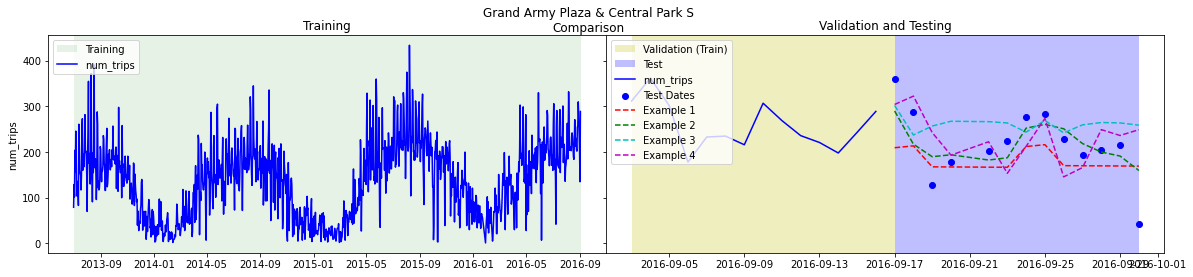

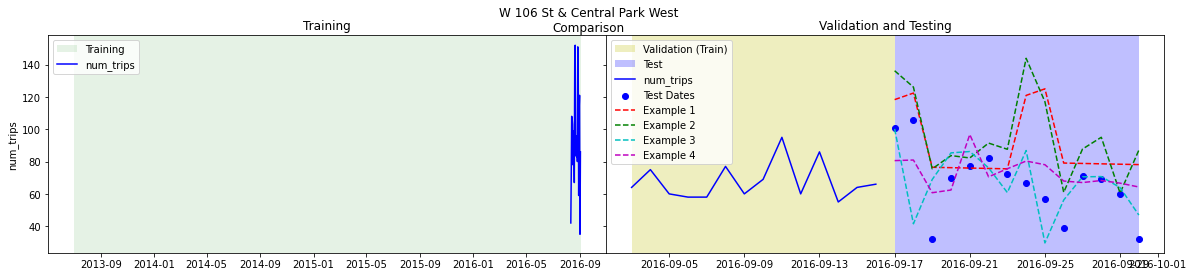

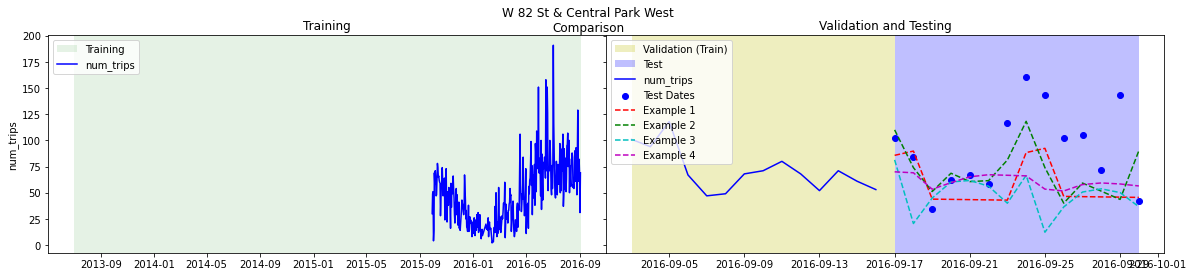

In [407]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]
        
        

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
        
        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        #axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')
        axes[1].scatter(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b', label = 'Test Dates')
        
        # Forecast
        fit_testdf = pred_ex1[(pred_ex1[SERIES_COLUMN] == st) & (pred_ex1[TIME_COLUMN] >= keyDates['test_start'][0])]
        axes[1].plot(fit_testdf[TIME_COLUMN], fit_testdf['predicted'], color = 'r', label = f'Example 1', linestyle='dashed')
        
        fit_testdf = pred_ex2[(pred_ex2[SERIES_COLUMN] == st) & (pred_ex2[TIME_COLUMN] >= keyDates['test_start'][0])]
        axes[1].plot(fit_testdf[TIME_COLUMN], fit_testdf['predicted'], color = 'g', label = f'Example 2', linestyle='dashed')
        
        fit_testdf = pred_ex3[(pred_ex3[SERIES_COLUMN] == st) & (pred_ex3[TIME_COLUMN] >= keyDates['test_start'][0])]
        axes[1].plot(fit_testdf[TIME_COLUMN], fit_testdf['predicted'], color = 'c', label = f'Example 3', linestyle='dashed')
        
        fit_testdf = pred_ex4[(pred_ex4[SERIES_COLUMN] == st) & (pred_ex4[TIME_COLUMN] >= keyDates['test_start'][0])]
        axes[1].plot(fit_testdf[TIME_COLUMN], fit_testdf['predicted'], color = 'm', label = f'Example 4', linestyle='dashed')

        
        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st + f"\nComparison")

        # display result
        plt.show()